# **Pre-processing**

In [1]:
import numpy as np
import pandas as pd
import json
import datetime

import re
import nltk
from nltk.corpus import stopwords

from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Reading the data from csv file and storing it in a variable named df means data-frame
df = pd.read_csv("../input/youtube-trending-video-dataset/US_youtube_trending_data.csv")

#Lets Check First 5 data in the table to analyse the variables
df.head()

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,3C66w5Z0ixs,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11T19:20:14Z,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,22,2020-08-12T00:00:00Z,brawadis|prank|basketball|skits|ghost|funny vi...,1514614,156908,5855,35313,https://i.ytimg.com/vi/3C66w5Z0ixs/default.jpg,False,False,SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...
1,M9Pmf9AB4Mo,Apex Legends | Stories from the Outlands – “Th...,2020-08-11T17:00:10Z,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,20,2020-08-12T00:00:00Z,Apex Legends|Apex Legends characters|new Apex ...,2381688,146739,2794,16549,https://i.ytimg.com/vi/M9Pmf9AB4Mo/default.jpg,False,False,"While running her own modding shop, Ramya Pare..."
2,J78aPJ3VyNs,I left youtube for a month and THIS is what ha...,2020-08-11T16:34:06Z,UCYzPXprvl5Y-Sf0g4vX-m6g,jacksepticeye,24,2020-08-12T00:00:00Z,jacksepticeye|funny|funny meme|memes|jacksepti...,2038853,353787,2628,40221,https://i.ytimg.com/vi/J78aPJ3VyNs/default.jpg,False,False,I left youtube for a month and this is what ha...
3,kXLn3HkpjaA,XXL 2020 Freshman Class Revealed - Official An...,2020-08-11T16:38:55Z,UCbg_UMjlHJg_19SZckaKajg,XXL,10,2020-08-12T00:00:00Z,xxl freshman|xxl freshmen|2020 xxl freshman|20...,496771,23251,1856,7647,https://i.ytimg.com/vi/kXLn3HkpjaA/default.jpg,False,False,Subscribe to XXL → http://bit.ly/subscribe-xxl...
4,VIUo6yapDbc,Ultimate DIY Home Movie Theater for The LaBran...,2020-08-11T15:10:05Z,UCDVPcEbVLQgLZX0Rt6jo34A,Mr. Kate,26,2020-08-12T00:00:00Z,The LaBrant Family|DIY|Interior Design|Makeove...,1123889,45802,964,2196,https://i.ytimg.com/vi/VIUo6yapDbc/default.jpg,False,False,Transforming The LaBrant Family's empty white ...


# **Variables Analysis**
There are 16 colums in the US dataset:

"video_id,title, title,publishedAt, channelId, channelTitle, categoryId, trending_date, tags,view_count, likes,dislikes, comment_count, thumbnail_link, comments_disabled, ratings_disabled, description"

Lets observe the variables that we might need

* **video_id**: Have alphabets and numbers. But we wont be neading it for analysis but it can be used as a prove that the video really exists and we didn't just randomly add any data.
* **trending_date**: Have the date when the video started trending.
* **title**: Title represents the whole video or we can say what the video is about but sometimes youtubers tend to add catchy or falsy words so that viewers click on the video in the motive of geting views.
* **channel_title**: Chanel name nothing much can be used to differentiate content creators.
* **category_id**: YouTube gives every video a catagory id based on the video or the chanel owner can set a catagory so that viewers can find the video faster using the filter options.
* **publishedAt**: When the video was actually published can be helpfull to know when the event started happning.
* **tags**: Tags are famous ways to connect videos in worldwide known words we can also say that these are unoffical catagorys commonly known by people/viewers.
* **views,likes,dislikes,comment_count**: Has numerical values it represents the ingagements of the video.
* **thumbnail_link**: have the url for the picture of the thumbnail. Oddly now adding exotic pics to thumbnails can bring more views. We can analys the pics but that topic is more advanced so we will not be doing that.
* **comments_disabled,ratings_disabled,video_error_or_removed**: Have bool values we think about it later if needed.
* **description**: Have description as string. Might contain emoji ar ascii values, we have to remove them if we use them for anylysis.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220588 entries, 0 to 220587
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   video_id           220588 non-null  object
 1   title              220588 non-null  object
 2   publishedAt        220588 non-null  object
 3   channelId          220588 non-null  object
 4   channelTitle       220588 non-null  object
 5   categoryId         220588 non-null  int64 
 6   trending_date      220588 non-null  object
 7   tags               220588 non-null  object
 8   view_count         220588 non-null  int64 
 9   likes              220588 non-null  int64 
 10  dislikes           220588 non-null  int64 
 11  comment_count      220588 non-null  int64 
 12  thumbnail_link     220588 non-null  object
 13  comments_disabled  220588 non-null  bool  
 14  ratings_disabled   220588 non-null  bool  
 15  description        216261 non-null  object
dtypes: bool(2), int64(5)

In [4]:
#Lets remove "video_id" and "thumbnail_link" we wont be needing those

df.drop(columns=['video_id','thumbnail_link'],inplace=True, errors='ignore')
#Lets check that if we had successfully removed the columns.
df.head(n=2)

,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,comments_disabled,ratings_disabled,description
0,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11T19:20:14Z,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,22,2020-08-12T00:00:00Z,brawadis|prank|basketball|skits|ghost|funny vi...,1514614,156908,5855,35313,False,False,SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...
1,Apex Legends | Stories from the Outlands – “Th...,2020-08-11T17:00:10Z,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,20,2020-08-12T00:00:00Z,Apex Legends|Apex Legends characters|new Apex ...,2381688,146739,2794,16549,False,False,"While running her own modding shop, Ramya Pare..."


**Catagory ID Mapping**

Currently, the category_id column contains the category id of each video, which is in the form of a number. We will replace the **category id** with the corresponding category title, as provided to us from in a json file from the original Kaggle dataset. To do this, we will create the dictionary **categoryID**, which will contain each category's information (i.e. kind, etag, id, title, etc.) We are only interested in the id and title, so we will create a separate dictionary called **ID_to_Category** which will just contain the id's as keys and the corresponding titles.

In [5]:
#We need to import json so that we can use its contents.

with open("../input/youtube-trending-video-dataset/US_category_id.json") as f: categoryID = json.load(f)
categoryID, l_c = categoryID['items'], len(categoryID['items'])
ID_to_Category = dict(zip([int(categoryID[i]['id']) for i in range(l_c)],
                          [categoryID[i]['snippet']['title'] for i in range(l_c)]))

In [6]:
ID_to_Category

{1: 'Film & Animation',
 2: 'Autos & Vehicles',
 10: 'Music',
 15: 'Pets & Animals',
 17: 'Sports',
 18: 'Short Movies',
 19: 'Travel & Events',
 20: 'Gaming',
 21: 'Videoblogging',
 22: 'People & Blogs',
 23: 'Comedy',
 24: 'Entertainment',
 25: 'News & Politics',
 26: 'Howto & Style',
 27: 'Education',
 28: 'Science & Technology',
 29: 'Nonprofits & Activism',
 30: 'Movies',
 31: 'Anime/Animation',
 32: 'Action/Adventure',
 33: 'Classics',
 34: 'Comedy',
 35: 'Documentary',
 36: 'Drama',
 37: 'Family',
 38: 'Foreign',
 39: 'Horror',
 40: 'Sci-Fi/Fantasy',
 41: 'Thriller',
 42: 'Shorts',
 43: 'Shows',
 44: 'Trailers'}

In [7]:
ID_to_Category.keys()

dict_keys([1, 2, 10, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44])

In [8]:
df.head(n=2)

,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,comments_disabled,ratings_disabled,description
0,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11T19:20:14Z,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,22,2020-08-12T00:00:00Z,brawadis|prank|basketball|skits|ghost|funny vi...,1514614,156908,5855,35313,False,False,SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...
1,Apex Legends | Stories from the Outlands – “Th...,2020-08-11T17:00:10Z,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,20,2020-08-12T00:00:00Z,Apex Legends|Apex Legends characters|new Apex ...,2381688,146739,2794,16549,False,False,"While running her own modding shop, Ramya Pare..."


In [9]:
df['categoryId'] = df['categoryId'].apply(lambda x: ID_to_Category[x])
#Lets see the result
df.head(n=2)

,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,comments_disabled,ratings_disabled,description
0,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11T19:20:14Z,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,People & Blogs,2020-08-12T00:00:00Z,brawadis|prank|basketball|skits|ghost|funny vi...,1514614,156908,5855,35313,False,False,SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...
1,Apex Legends | Stories from the Outlands – “Th...,2020-08-11T17:00:10Z,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,Gaming,2020-08-12T00:00:00Z,Apex Legends|Apex Legends characters|new Apex ...,2381688,146739,2794,16549,False,False,"While running her own modding shop, Ramya Pare..."


**Data Instancing**

Both the **trending_date** and **publishedAt** columns have dates, but in different format. Publish_time includes the time of publication and date, while trending_date only have the date. Since we don't have the time the video started trending, we cannot compare it to the publish time. In the end, we will clean the data such that both columns include datatime.date objects.

In [10]:
#2020-08-11T19:20:14Z
def clean_trending_date(date):
    y,m,d = date.split('T')[0].split('-')
    return datetime.date(int(y), int(m), int(d))

def clean_publish_time(time):
    y,m,d = time.split('T')[0].split('-')
    return datetime.date(int(y), int(m), int(d))

In [11]:
df['trending_date'] = df['trending_date'].apply(clean_trending_date)
df['publishedAt'] = df['publishedAt'].apply(clean_publish_time)

#Lets check the result
df.head(n=2)

,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,comments_disabled,ratings_disabled,description
0,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,People & Blogs,2020-08-12,brawadis|prank|basketball|skits|ghost|funny vi...,1514614,156908,5855,35313,False,False,SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...
1,Apex Legends | Stories from the Outlands – “Th...,2020-08-11,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,Gaming,2020-08-12,Apex Legends|Apex Legends characters|new Apex ...,2381688,146739,2794,16549,False,False,"While running her own modding shop, Ramya Pare..."


**Tag Splitting**

Now lets clean up the **tags** column by separating tags into a list instead of one long string.

In [12]:
def clean_tags(tag):
    if tag == '[none]': return []
    return tag.lower().replace('"','').split('|')

In [13]:
df['tags'] = df['tags'].apply(clean_tags)
df.head(n=2)

,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,comments_disabled,ratings_disabled,description
0,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,People & Blogs,2020-08-12,"[brawadis, prank, basketball, skits, ghost, fu...",1514614,156908,5855,35313,False,False,SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...
1,Apex Legends | Stories from the Outlands – “Th...,2020-08-11,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,Gaming,2020-08-12,"[apex legends, apex legends characters, new ap...",2381688,146739,2794,16549,False,False,"While running her own modding shop, Ramya Pare..."


**Natural Language processing for Title**

This time we will clean the **video title** and keep only the nececary words. So that, we can better analys certain keywords being used in the titles.

In [14]:
def clean_titles(title):
    tokens = title.lower().split()
    cleaned = []
    sw = set(stopwords.words('english'))
    for token in tokens:
        if token.startswith('$') or token.isnumeric() or not token.isalnum() or token in sw:  # Remove money amount, non-alphanumeric tokens, or stopwords
            continue
        else:
            cleaned.append(token)
    return ' '.join(cleaned)

df['title_cl'] = df['title'].apply(clean_titles)

#Lets check for result
df.head(n=2)

,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,comments_disabled,ratings_disabled,description,title_cl
0,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,People & Blogs,2020-08-12,"[brawadis, prank, basketball, skits, ghost, fu...",1514614,156908,5855,35313,False,False,SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...,asked
1,Apex Legends | Stories from the Outlands – “Th...,2020-08-11,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,Gaming,2020-08-12,"[apex legends, apex legends characters, new ap...",2381688,146739,2794,16549,False,False,"While running her own modding shop, Ramya Pare...",apex legends stories outlands


# **Data Visualization**

**Co-Relation Between Some Numerical Values**

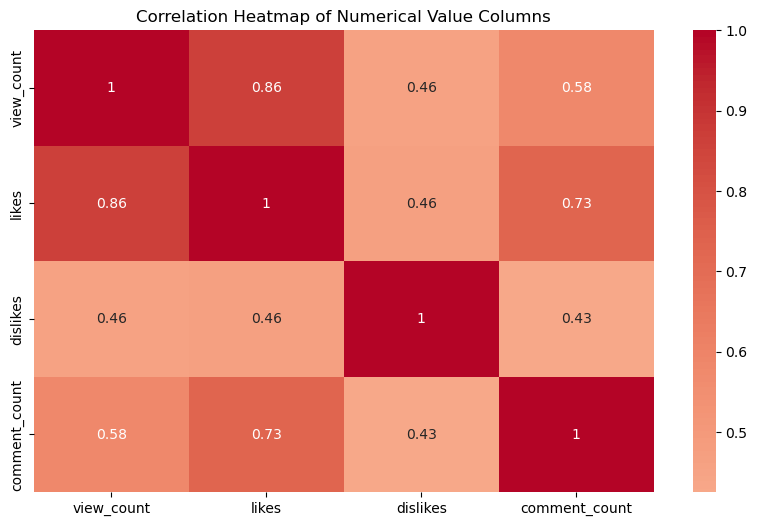

In [15]:
# Select numerical columns
numerical_columns = ['view_count', 'likes', 'dislikes', 'comment_count']

# Calculate correlation matrix
correlation_matrix = df[numerical_columns].corr()

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Numerical Value Columns')
plt.show()

**Title Word Choice** 

Now that we have nicely cleaned our data, we will start analysing our data. We will start from what words are mostly used in video titles by counting how many the same words has been used and folow on after that first lets find them.

In [16]:
cnt = Counter()

# Finding the occurence of words in video titles
for title in df['title_cl']:
    for token in title.split():
        cnt[token] += 1

# Finding the 50 most used words in video titles
dist = cnt.most_common(50)
top_words = []
freqs = []
for word, freq in dist:
    top_words.append(word)
    freqs.append(freq)

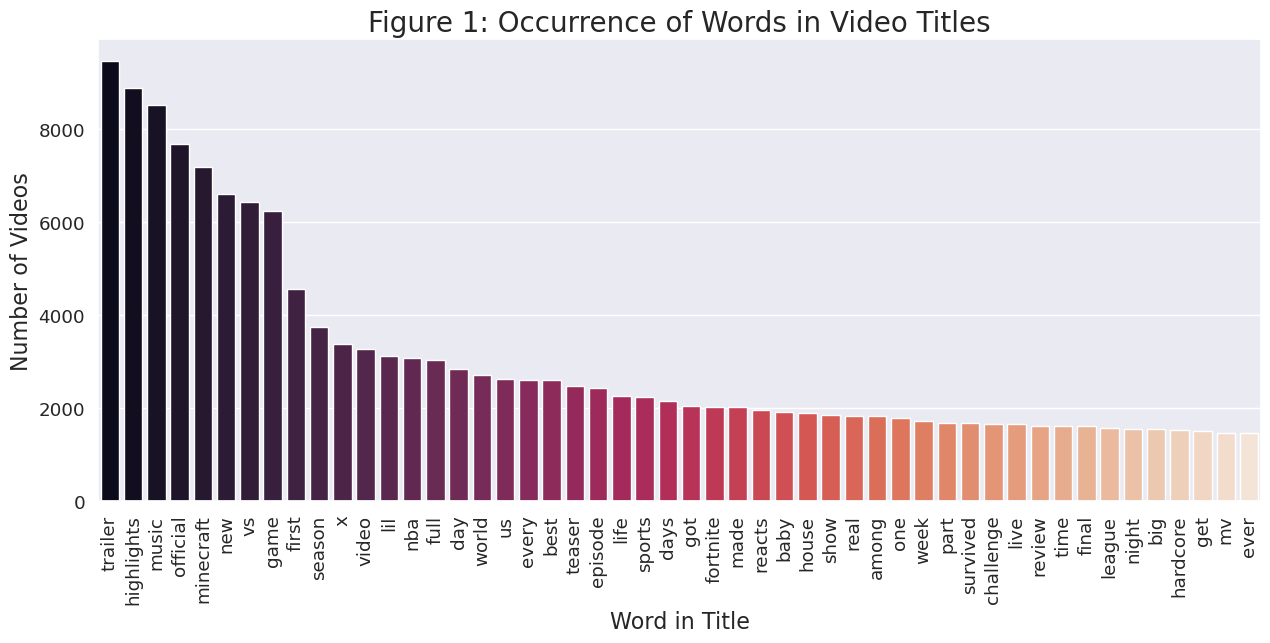

In [17]:
# Graphing number of times the world occure in title
fig= plt.figure(figsize=(15,6))
sns.set_style("darkgrid")
sns.set(font_scale=1.2)

sns.barplot(x=top_words,y=freqs, palette="rocket")

plt.xticks(rotation=90)
plt.xlabel('Word in Title', fontsize=16)
plt.ylabel('Number of Videos', fontsize=16)
plt.title('Figure 1: Occurrence of Words in Video Titles', fontsize=20)
plt.show()

From Figure 1, We can see that the top ten words are **trailer, highlights, music, official, minecraft, new, vs, game, first, season** it seems that some words quict nicely go together like "official trailer", "new music", "official music", "new game", "new season", "new minecraft season", etc...

**Video Catagories**

Now we will find what catagory of trending videos are most and least common by looking at the frequencies of video categories.

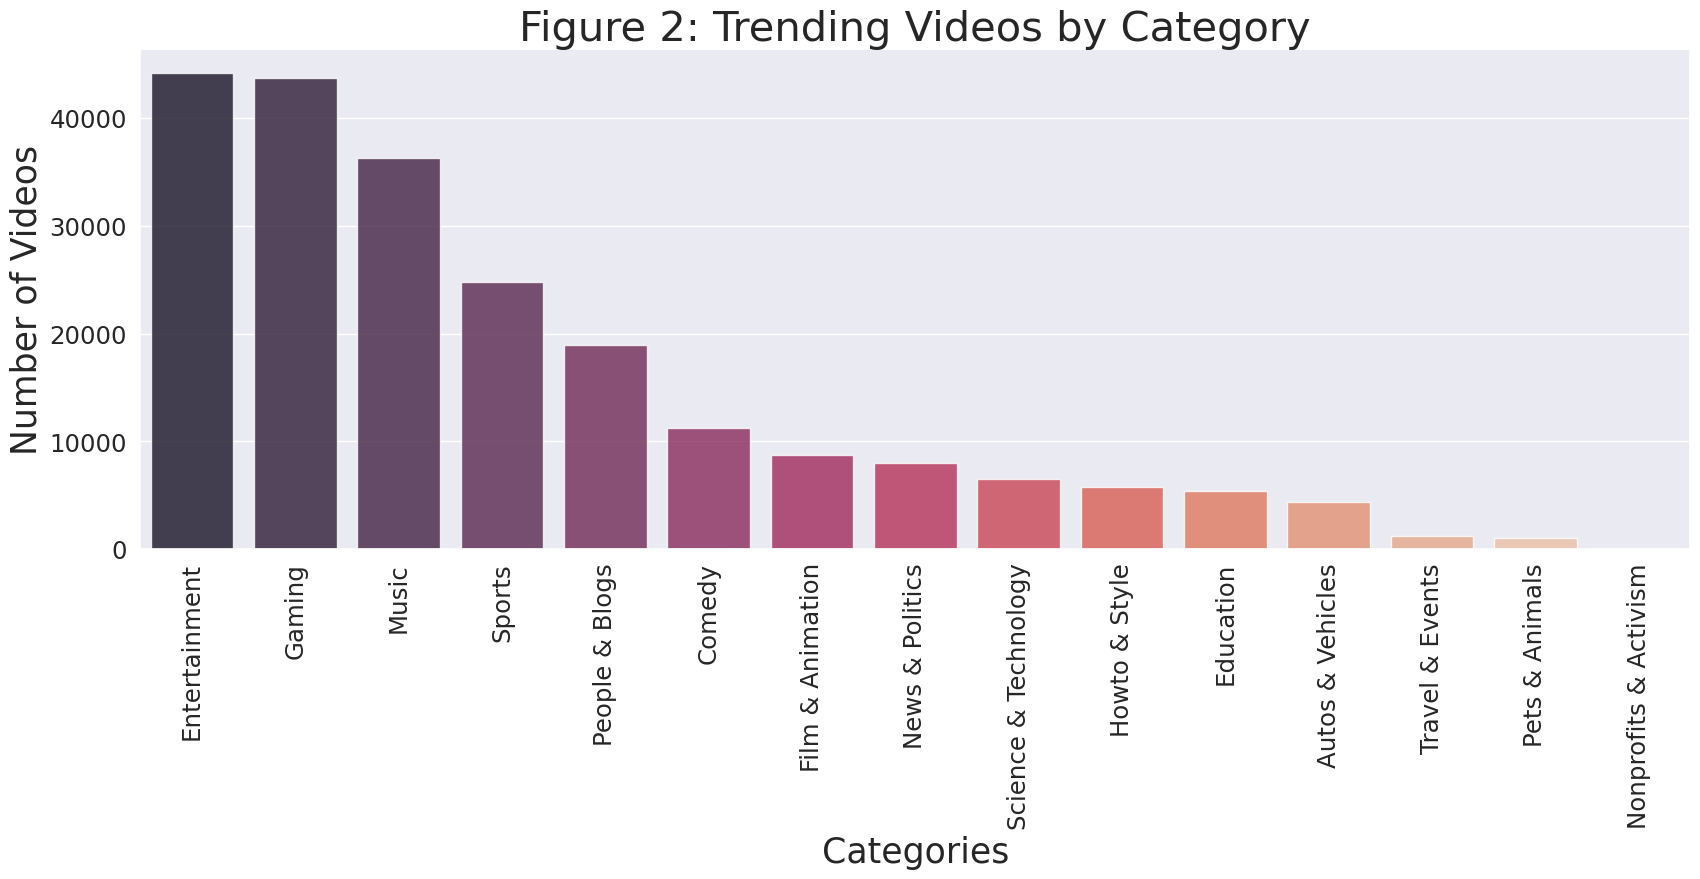

In [18]:
# Bar graph for number of videos per category
sns.set_style("darkgrid")
sns.set(font_scale=1.6)

categories = df['categoryId'].value_counts()

plt.figure(figsize=(20,6.5))
sns.barplot(x=categories.index, y=categories.values, alpha=0.8, palette="rocket")

sns.set(font_scale=1.6)
plt.xticks(rotation=90)
plt.xlabel('Categories', fontsize=25)
plt.ylabel('Number of Videos', fontsize=25)
plt.title('Figure 2: Trending Videos by Category', fontsize=30)
plt.show()

From Figure 2, we can see that the Entertainment category has the most number of trending videos with about 45,000 approximate which accounts for about a one fifth of the videos in this dataset. Similarly we can also see that the Gaming category has almost same but less amount of videos about 42,000 approximate which accounts for another one fifth of the vidoes in the dataset. The Music catagory has vidoe count bellow 40,000 but no other catagory has even reached 30,000 other then music but lets not negate the fact that the sport catagory has over 25,000 video count other then these four major catagory rest of them dosent even have 20,000 video count.

To see the percentage of these four categories more acurately lets run the following code additionally lets see for the least 3 categories also.

In [19]:
# Caculating the percentages for top 4 categories
entertainment = df[df['categoryId'] == 'Entertainment']['categoryId'].count() / df['categoryId'].count() * 100
gaming = df[df['categoryId'] == 'Gaming']['categoryId'].count() / df['categoryId'].count() * 100
music = df[df['categoryId'] == 'Music']['categoryId'].count() / df['categoryId'].count() * 100
sports = df[df['categoryId'] == 'Sports']['categoryId'].count() / df['categoryId'].count() * 100

# Calculating the percentages for bottom 3 categories
travelandevents = df[df['categoryId'] == 'Travel & Events']['categoryId'].count() / df['categoryId'].count() * 100
petsandanimals = df[df['categoryId'] == 'Pets & Animals']['categoryId'].count() / df['categoryId'].count() * 100
nonprofits = df[df['categoryId'] == 'Nonprofits & Activism']['categoryId'].count() / df['categoryId'].count() * 100

In [20]:
#Lets print the percentages
print("Top 5:")
print("Entertainment:",entertainment)
print("Gaming:",gaming)
print("Music:",music)
print("Sports:",sports)
print("\n")
print("Least 3:")
print("Travel & Events:",travelandevents)
print("Pets & Animals",petsandanimals)
print("Nonprofits & Activism",nonprofits)

Top 5:
Entertainment: 20.05050138720148
Gaming: 19.833807822728346
Music: 16.47777757629608
Sports: 11.257185340997697


Least 3:
Travel & Events: 0.5684806063793134
Pets & Animals 0.4556004859738517
Nonprofits & Activism 0.05168005512539213


After doing the calculation for the percentages of categories, it is noteworthiy that **Entertainment**(20.05%), **Gaming**(19.79%), **Music**(16.49%), **Sports**(11.24%) make up 67.67% of the trending videos. The common thing is that these type of videos are mostly leisure type except for sports.

**Channel Frequencies**

Now lets see which chanels have a large number of trending videos. Based on our previous catagory analysis, we can assume that the channels with the most number of trending videos will be Entertainment, Gaming, Music and Sports chanel.
We can start by calculating the trending video frequency for each channel.

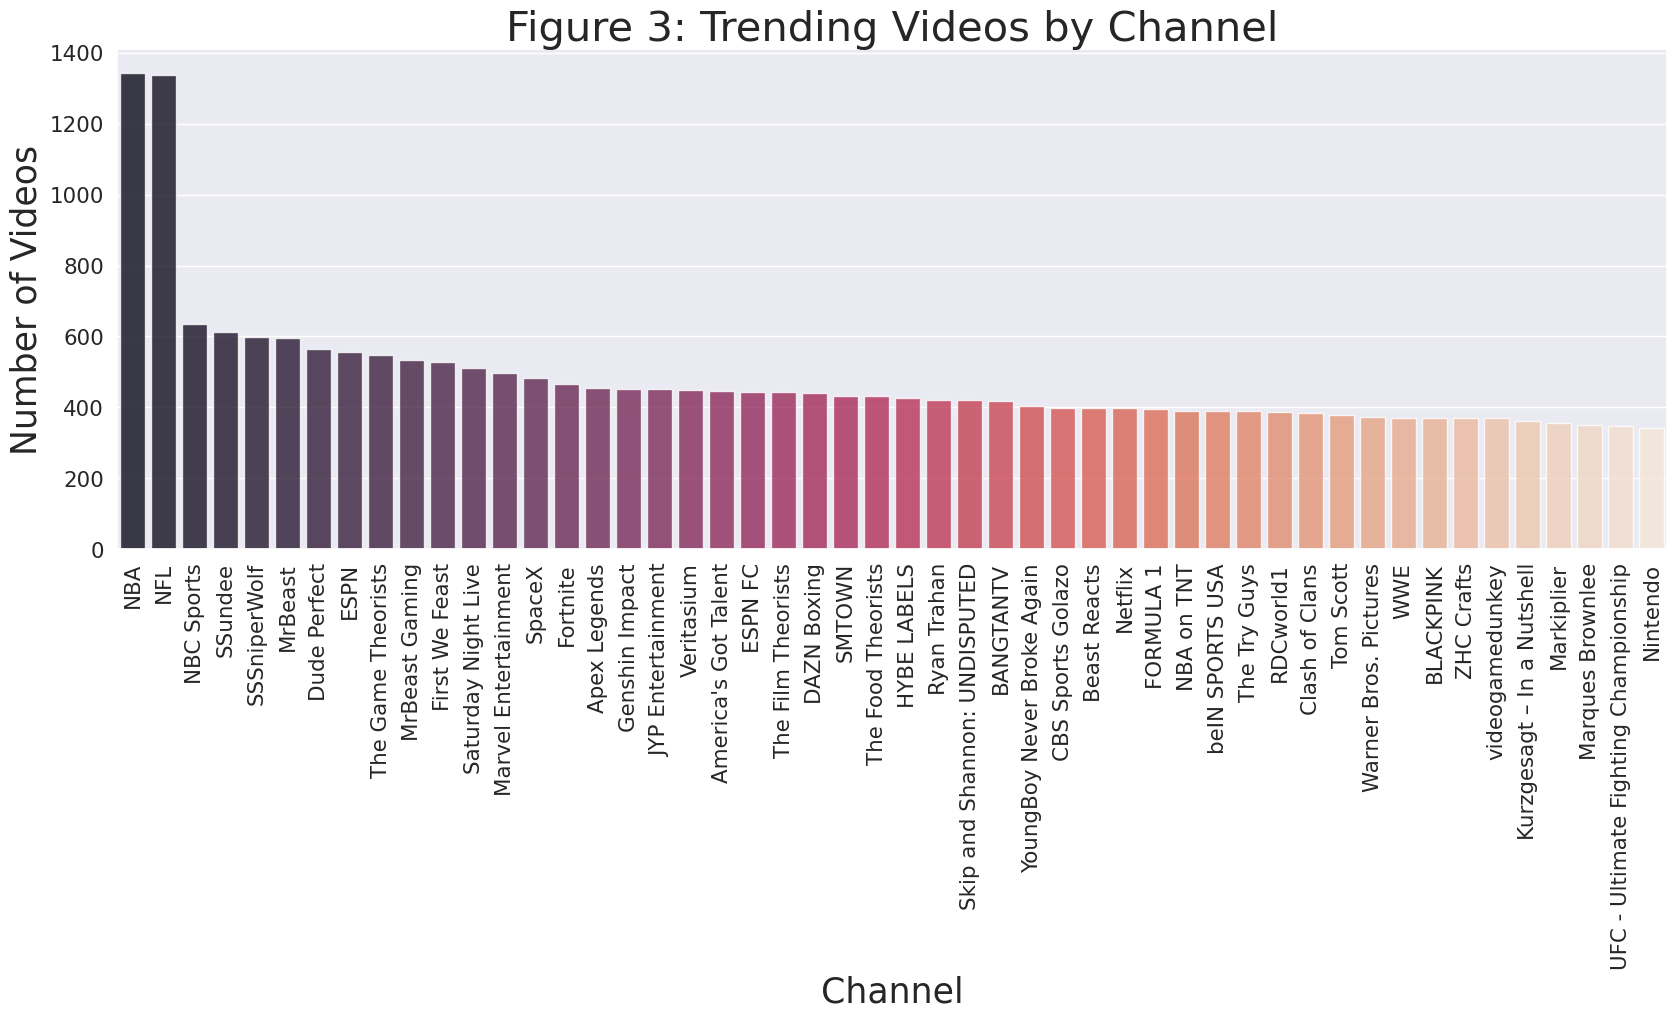

In [21]:
sns.set_style("darkgrid")
sns.set(font_scale=1.4)

channel_freq = df['channelTitle'].value_counts()
channel_freq = channel_freq[0:50]

# Bar graph for number of videos for the top 50 channels
plt.figure(figsize=(20, 6.5))
sns.barplot(x=channel_freq.index, y=channel_freq.values, alpha=0.8, palette="rocket")

plt.xticks(rotation=90)
plt.xlabel('Channel', fontsize=25)
plt.ylabel('Number of Videos', fontsize=25)
plt.title('Figure 3: Trending Videos by Channel', fontsize=30)
plt.show()

From, the graph, we can see that **NBA**(near 1300+ videos), neek to neek **NFL**(near 1300 videos), after these two others are starting from **NBC Sports**(600+ videos) and rest of them are near 600 or less then 600 to 400. Here is the top 10 chanels with trending videos and their respective Catagory.

* NBA: Sports
* NFL: Sports
* NBC Sports: Sports
* SSundee: Gaming
* SSSniperWlof: Reaction, Vlogs, Gaming
* MrBeast: Entertainment, Vlogs, Gaming
* Dude Perfect: Sports & Vlogs
* ESPN: Sports
* The Game Theorists: Education & Gaming
* MrBeast Gaming: Gaming

In [22]:
channel_freq[0:10]

NBA                   1344
NFL                   1338
NBC Sports             634
SSundee                613
SSSniperWolf           599
MrBeast                595
Dude Perfect           565
ESPN                   556
The Game Theorists     548
MrBeast Gaming         535
Name: channelTitle, dtype: int64

So we can easily say that NBA & NFL are untuchable in number of trending videos.

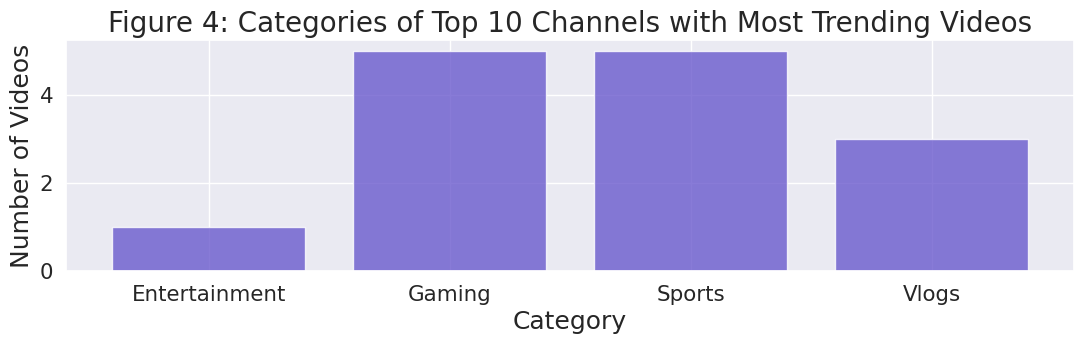

In [23]:
d = {'Entertainment': 1, 'Gaming': 5, 'Sports': 5, 'Vlogs': 3}

# Bar graph for the number of videos per category for the top 10 channels with trending videos
plt.figure(figsize=(13,3))
plt.bar(range(len(d)), list(d.values()), align='center', alpha=0.8, 
        color="slateblue")
plt.xticks(range(len(d)), list(d.keys()))
plt.xlabel("Category", fontsize=18)
plt.ylabel("Number of Videos",fontsize=18)
plt.title('Figure 4: Categories of Top 10 Channels with Most Trending Videos', 
          fontsize=20)
plt.show()

Our earlier Exploration of the catagories suports the fact that almost 20% of the videos are Gaming but it seems that many chanels that produce entertainment contents but the cahnel itself dosent identify or belong into an Entertainment catagory another case could be that entertainment contents are not made by top 10 chanels and for the case of Music it seems like most of the channels are personal chanel so the content creators mostly vlog and in the other videos they produce music and when they make music they gets viral nad gets into trending page and the videos itself gets into Music catagory. So we will do another histogram for chanel frequencies.

Text(0.5, 1.0, 'Figure 5: Frequency of Channels with Trending Videos')

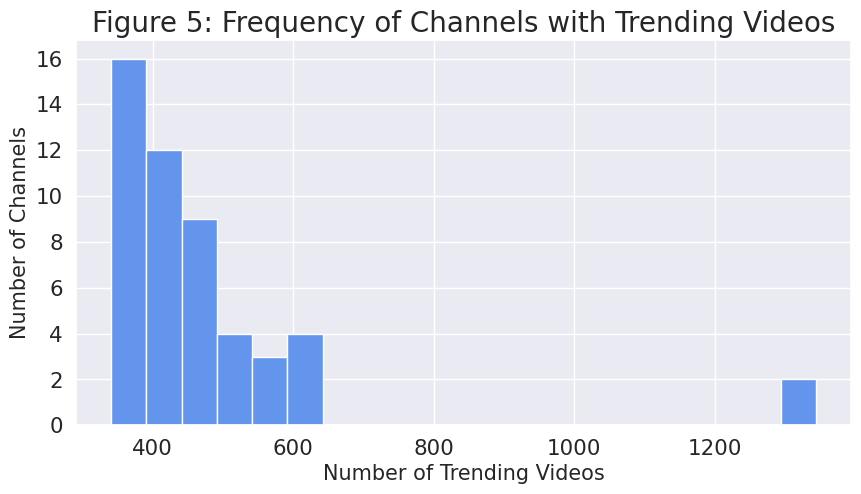

In [24]:
# Histogram for channel frequencies
plt.figure(figsize=(10,5))
channel_freq.hist(bins=20, color="cornflowerblue")
plt.xlabel("Number of Trending Videos", fontsize=15)
plt.ylabel("Number of Channels", fontsize=15)
plt.title('Figure 5: Frequency of Channels with Trending Videos', fontsize=20)

This hsitogram, Figure 5, helps us understand why the top 10 channels with trending videos may not match with the exploration of categories we did earlier as the distribution is extremely right skewed. Only 2 chanels have 1350 trending videos, while we have a few channels with over 600 videos. We will calculate the percentages fo the number of trending videos that channels have to look at the distribution more closely.

In [25]:
# Percentage of number of trending videos a channel has
above_20 = len([i for i in channel_freq if i > 1000]) / len(channel_freq) * 100
percent_16_20 = len([i for i in channel_freq if (i <= 1000) & (i > 800)]) / len(channel_freq) * 100
percent_11_15 = len([i for i in channel_freq if (i <= 800) & (i > 700)]) / len(channel_freq) * 100
percent_6_10 = len([i for i in channel_freq if (i <= 700) & (i > 600)]) / len(channel_freq) * 100
percent_1_5 = len([i for i in channel_freq if (i <= 600)]) / len(channel_freq) * 100

In [26]:
#Lets print the percentages
print("Above 1000:",above_20)
print("Between 1000 to 800:",percent_16_20)
print("Between 800 to 700:",percent_11_15)
print("Between 700 to 600:",percent_6_10)
print("Between 600 and bellow:",percent_1_5)

Above 1000: 4.0
Between 1000 to 800: 0.0
Between 800 to 700: 0.0
Between 700 to 600: 4.0
Between 600 and bellow: 92.0


This demonstrates that more than 9/10 chanels have created under 700 videos, with 92% of channels having 600 and bellow videos. This shows us that the top channels with over 1000 trending videos are outliers.

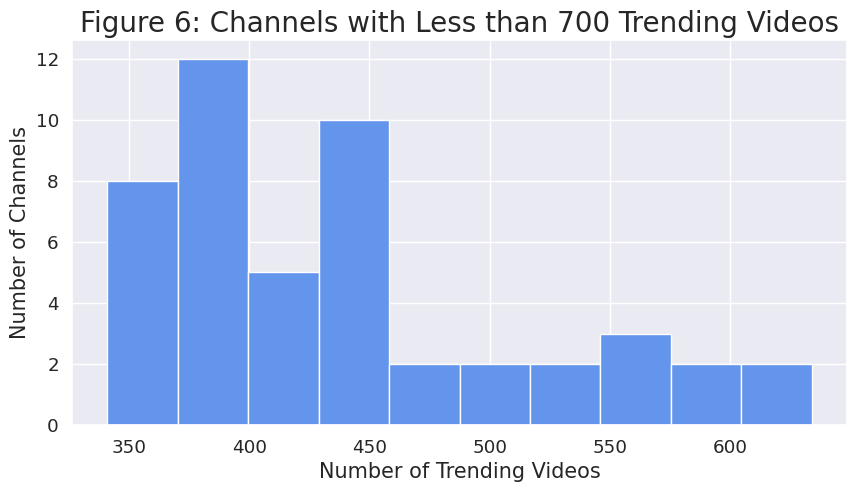

In [27]:
# Histogram for number of channels vs number of trending videos below 20
sns.set_style("darkgrid")
sns.set(font_scale=1.2)

plt.figure(figsize=(10, 5))
channel_freq[channel_freq<700].hist(bins=10, color='cornflowerblue')

plt.xlabel("Number of Trending Videos", fontsize=15)
plt.ylabel("Number of Channels", fontsize=15)
plt.title("Figure 6: Channels with Less than 700 Trending Videos", fontsize=20)

plt.show()

**Exploration of Views**

In [28]:
df.describe()

,view_count,likes,dislikes,comment_count
count,2.205880e+05,2.205880e+05,220588.000000,2.205880e+05
mean,2.537280e+06,1.285038e+05,1382.119812,1.056426e+04
std,7.418590e+06,4.142769e+05,8863.768086,7.859201e+04
min,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
25%,4.762740e+05,1.833375e+04,0.000000,1.309000e+03
50%,9.542755e+05,4.167250e+04,0.000000,2.870000e+03
75%,2.142892e+06,1.029692e+05,701.000000,6.707000e+03
max,2.777917e+08,1.602153e+07,879354.000000,6.738537e+06


In [29]:
df.median(numeric_only='None')

view_count           954275.5
likes                 41672.5
dislikes                  0.0
comment_count          2870.0
comments_disabled         0.0
ratings_disabled          0.0
dtype: float64

* **Average number of views**: 2,533,463
* **Median number of views**: 955,630
* With the average being so much larger than the median, this tels that the distribution of views is strongly skewed to the right.

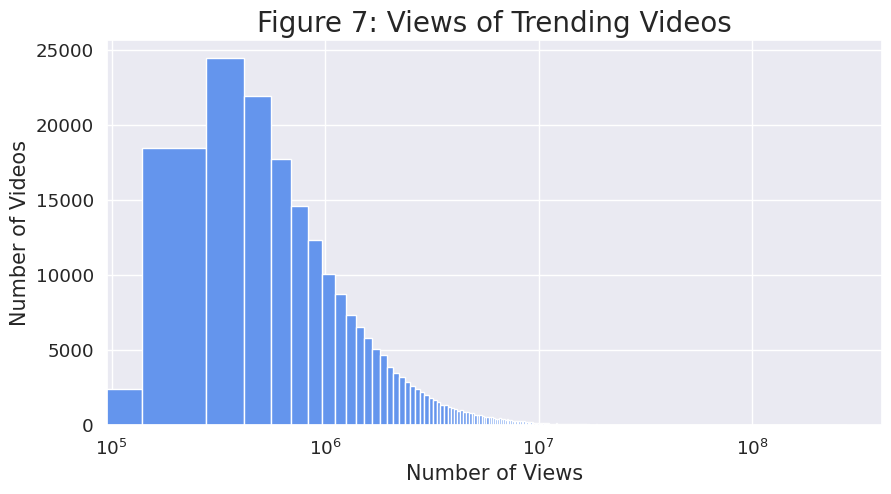

In [30]:
# Histogram of the views data for all the videos
sns.set_style("darkgrid")
sns.set(font_scale=1.2)

plt.figure(figsize=(10, 5))
v1 = df['view_count'].hist(bins=2000, color='cornflowerblue')

plt.xscale('log') # Set x-axis to logarithmic scale
plt.xlabel('Number of Views', fontsize=15)
plt.ylabel('Number of Videos', fontsize=15)
plt.title('Figure 7: Views of Trending Videos', fontsize=20)

plt.show()

Figure 7 shows that the distribution is very right skewed and shows us that the majority of videos under million. We will plot another histogram to look at the distribution a little bit closer.

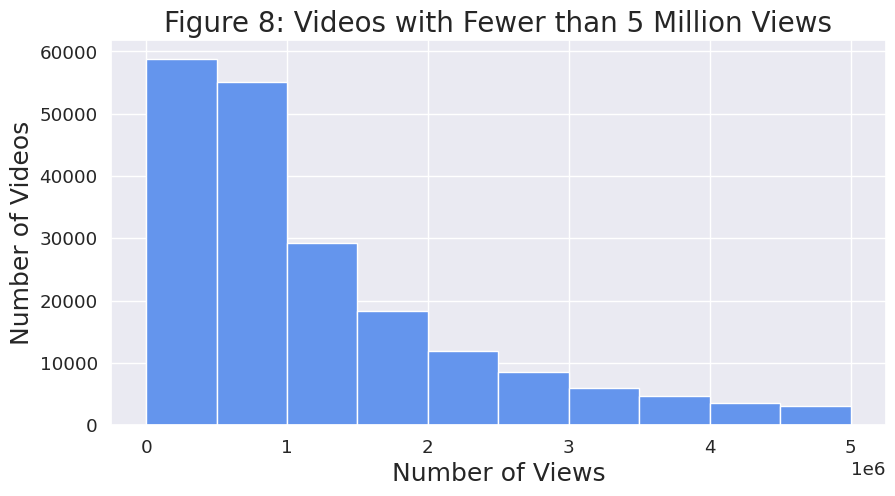

In [31]:
sns.set_style("darkgrid")
sns.set(font_scale=1.2)

v5million = df[df['view_count'] < 5e6]['view_count']

plt.figure(figsize=(10, 5))
v2 = v5million.hist(color='cornflowerblue')

plt.xlabel('Number of Views', fontsize=18)
plt.ylabel('Number of Videos', fontsize=18)
plt.title('Figure 8: Videos with Fewer than 5 Million Views', fontsize=20)

plt.show()

Now it is easy to see that the majority of videos have under 1 million views. We will calculate the exact percentage below.

In [32]:
views_2 = df[df['view_count'] < 2e6]['view_count'].count() / df['view_count'].count() * 100
#views_1 = df[df['view_count'] < 1e6]['view_count'].count() / df['view_count'].count() * 100
views_1 = 100-views_2

print("% videos with under 2 million views: ", views_2)
print("% videos with under 1 million views: ", views_1)

% videos with under 2 million views:  73.21431809527263
% videos with under 1 million views:  26.78568190472737


**Exploration of Likes**

* Average number of likes: 128,000
* Median number of likes: 41,777

This tells us that the distribution of views is strongly skewed to the right, with the majority of videos having below 41,777 likes. To visualize the data we will create a histogram of the like data for all the videos.

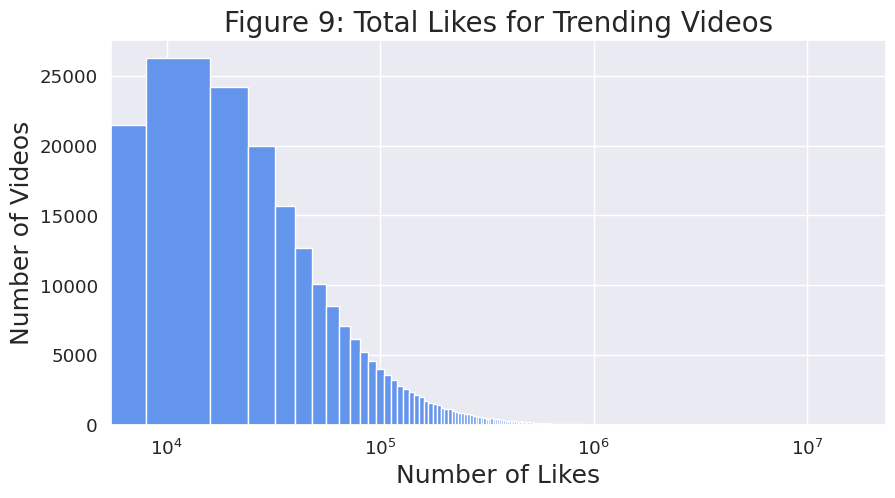

In [33]:
sns.set_style("darkgrid")
sns.set(font_scale=1.2)

plt.figure(figsize=(10, 5))
l1 = df['likes'].hist(bins=2000, color='cornflowerblue')

plt.xscale('log')
plt.xlabel('Number of Likes', fontsize=18)
plt.ylabel('Number of Videos', fontsize=18)
plt.title('Figure 9: Total Likes for Trending Videos', fontsize=20)

plt.show()

Figure 9 confirms that the distribution skewed to the right and shows us that the majority of videos have under 500,000 likes. We will plot another histogram for videos with lieks bellow 40,000 as this seems to be the amount that most trending videos have.

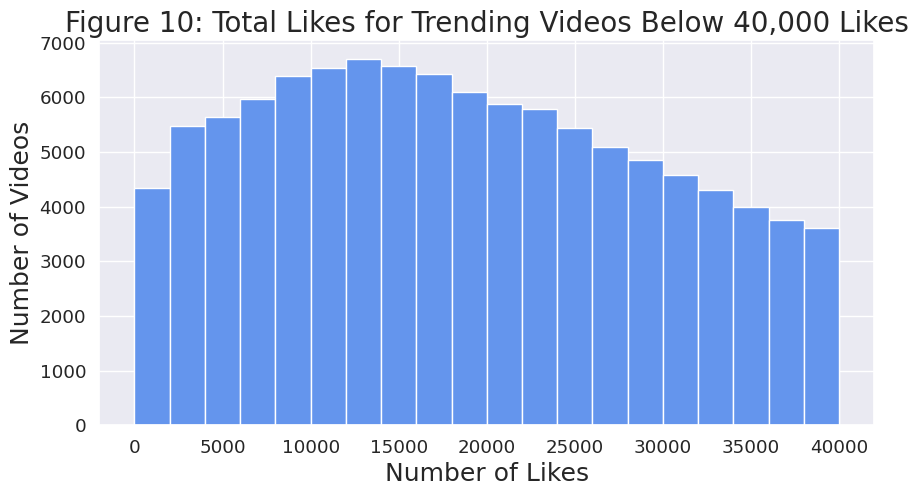

In [34]:
# Subset of likes below 40,000
sns.set_style("darkgrid")
sns.set(font_scale=1.2)

below40000 = df[df['likes'] < 4e4]['likes']

plt.figure(figsize=(10, 5))
l2 = below40000.hist(bins=20, color='cornflowerblue')

plt.xlabel('Number of Likes', fontsize=18)
plt.ylabel('Number of Videos', fontsize=18)
plt.title('Figure 10: Total Likes for Trending Videos Below 40,000 Likes', fontsize=20)

plt.show()

In [35]:
# Finding max number of likes
print("max number of likes: ", df['likes'].max())

# Finding min number of likes; excluding videos with 0 likes as those are for videos with ratings disabled
nonzero = df[df['likes'] != 0]
print("min number of likes: ", nonzero['likes'].min())
print()

# Finding number of videos with max and min number of likes
print("num with max: ", len(df[df['likes'] == df['likes'].max()]['likes']))
print("num with min: ", len(nonzero[nonzero['likes'] == 1]['likes']))

max number of likes:  16021534
min number of likes:  17

num with max:  1
num with min:  0


In [36]:
# Drop duplicates based on other columns (e.g., 'title')
unique_df = df.drop_duplicates(subset='title')

# Sort the unique DataFrame based on 'likes' column in descending order
sorted_unique_df = unique_df.sort_values(by='likes', ascending=False)
# Sort the unique DataFrame based on 'dislikes' column in descending order
sorted_unique_df2 = unique_df.sort_values(by='dislikes', ascending=False)

# Print the titles and like counts of the top videos
print("Titles and Like Counts of the Most Liked Trending Videos (No Duplicates):")
for index, row in sorted_unique_df.head(n=10).iterrows():
    print("Title:", row['title'])
    print("Likes:", row['likes'])
    print("------")

# Print the titles and like counts of the least videos
print("######")
print("Titles and Like Counts of the Most Disliked Trending Videos (No Duplicates):")
for index, row in sorted_unique_df2.head(n=5).iterrows():
    print("Title:", row['title'])
    print("Dislikes:", row['dislikes'])
    print("------")

Titles and Like Counts of the Most Liked Trending Videos (No Duplicates):
Title: BTS (방탄소년단) 'Butter' Official MV
Likes: 7110071
------
Title: BTS (방탄소년단) 'Dynamite' Official MV
Likes: 7045907
------
Title: LISA - 'LALISA' M/V
Likes: 5921316
------
Title: BLACKPINK - 'Ice Cream (with Selena Gomez)' M/V
Likes: 5912778
------
Title: 정국 (Jung Kook) 'Seven (feat. Latto)' Official MV
Likes: 5771591
------
Title: SHAKIRA || BZRP Music Sessions #53
Likes: 5406359
------
Title: Crazy #alluarjun #painting  #shorts #viral #trending
Likes: 5311001
------
Title: JISOO - ‘꽃(FLOWER)’ M/V
Likes: 5249480
------
Title: BTS (방탄소년단) 'Life Goes On' Official MV
Likes: 5177871
------
Title: BTS (방탄소년단) 'Butter (Hotter Remix)' Official MV
Likes: 5110687
------
######
Titles and Like Counts of the Most Disliked Trending Videos (No Duplicates):
Title: BLACKPINK - 'Ice Cream (with Selena Gomez)' M/V
Dislikes: 405329
------
Title: Cardi B - WAP feat. Megan Thee Stallion [Official Music Video]
Dislikes: 382578
--

The top most liked trending videos are Music videos now we can truely see that Music videos rulles the Main Trending page of YouTube. The thing we cant overlook that in the top most liked trending music videos 6 of them are Created by BTS or any singular members and the number one is (BTS (방탄소년단) 'Butter' Official MV) has 7,110,071 likes. On the other side the most disliked videos, some of them are from most liked videos. So we can say the dislikes ratio is oddly proportional to the ammount of likes the video has.

**Data Cleaning After Exploration**

We will drop all video that have comments disabled, rattings (likes and dislikes) disabled, or video error or removed for our analysis portion as we cannot measure the videos level of engagement without these pieces of information also have features disabeld, so these videos are some outliers in our data, which we don't want to use in our analysis.

In [37]:
print(df.columns)

Index(['title', 'publishedAt', 'channelId', 'channelTitle', 'categoryId',
       'trending_date', 'tags', 'view_count', 'likes', 'dislikes',
       'comment_count', 'comments_disabled', 'ratings_disabled', 'description',
       'title_cl'],
      dtype='object')


In [38]:
df.drop(df[(df['comments_disabled'] == True) | (df['ratings_disabled'] == True)].index, inplace=True)
df.drop(df[(df['likes'] == 0) & (df['dislikes'] == 0) & (df['comment_count'] == 0)].index, inplace=True)
df.drop(columns=['comments_disabled', 'ratings_disabled'], errors='ignore',inplace=True)

In [39]:
print(df.columns)

Index(['title', 'publishedAt', 'channelId', 'channelTitle', 'categoryId',
       'trending_date', 'tags', 'view_count', 'likes', 'dislikes',
       'comment_count', 'description', 'title_cl'],
      dtype='object')


# **Data Analysis and Results**

**Analysis 1: Engagement Correlation**

During our data visualization, we observed that the majority of trending YouTube videos have their ratings (like and dislike button) and comments active, with a small sliver of videos with them disabled. This seems odd as one would predict that engagement through ratings and comments would help increase video views by keeping the video in the limelight. Maybe creators disable these features to keep out dislikes and potentially negative comments, but what if getting dislikes increases a video's engagement, thus increasing its "popularity". This is what we will try to figure out in our first analysis.

> **Questions May Arise:** Do more dislikes indicate higher engagement rate (like dislike ratio or dislike rate or maybe bad comment rate)? Can this be extended to a specific category?
>**Probable Answere:** More dislikes might corelate with a grater comment rate. This might mainly happen in the News & Politics category, more then other categories.



In [40]:
# Using df_1 for Analysis 1
df_1 = df.copy()

**Dislike & Engagement Measurement**

For our analysis of dislikes, we will look at both **dislike rate**, which indicate to the amount of dislikes compared to tatal number of views, and **dislike ratio**, which indicate to the amount of dislikes compared to the total number of ratings(likes + dislikes). And our defination of engagement rate will be called **comment rate**, which indicates to the amount of comments in comparison to total number of video views.

In [41]:
# Create converted rates/ratio columns
df_1['comment_rate'] = df_1['comment_count'] / df_1['view_count']
df_1['dislike_rate'] =  df_1 ['dislikes'] / df_1['view_count']
df_1['dislike_ratio'] = df_1['dislikes'] / (df_1['dislikes'] + df_1['likes'])

**Distribution Visualization**

Now lets plot the distribution for the comment rate, dislike rate, and dislike ratio to get a feeling for the shape of the distribution.

In [42]:
df_1 = df_1.replace([np.nan,np.inf,-np.inf],0)

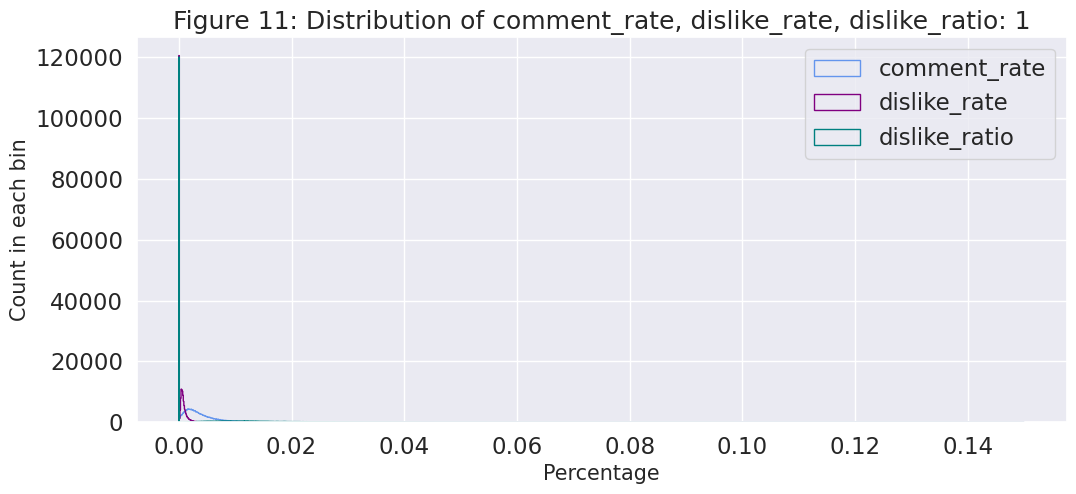

In [43]:
# Plot distribution of comment rate, dislike rate, and dislike ratio
sns.set(font_scale=1.5)  # Set font scale for all plots

plt.figure(figsize=(12, 5))
plt.hist(df_1['comment_rate'], label='comment_rate', bins=1500, color='cornflowerblue', histtype='step', range=(0, 0.15))
plt.hist(df_1['dislike_rate'], label='dislike_rate', bins=1500, color='purple', histtype='step', range=(0, 0.15))
plt.hist(df_1['dislike_ratio'], label='dislike_ratio', bins=1500, color='teal', histtype='step', range=(0, 0.15))
plt.title("Figure 11: Distribution of comment_rate, dislike_rate, dislike_ratio: 1", fontsize=18)
plt.xlabel("Percentage", fontsize=15)
plt.ylabel("Count in each bin", fontsize=15)
plt.legend()
plt.show()

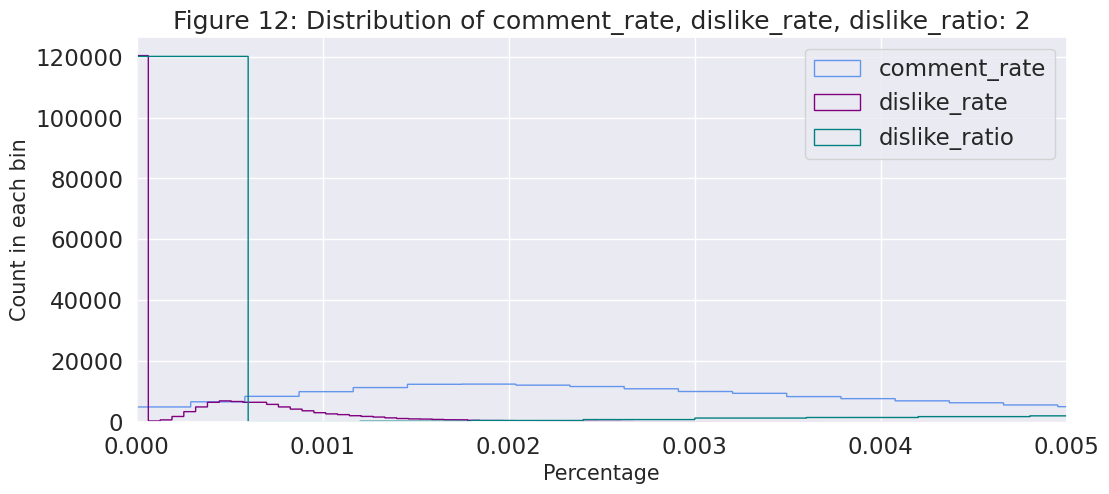

In [44]:
# Plot distribution of comment rate, dislike rate, and dislike ratio
plt.figure(figsize=(12,5))
plt.hist(df_1['comment_rate'],label='comment_rate',bins=1500,color='cornflowerblue', histtype='step')
plt.hist(df_1['dislike_rate'],label='dislike_rate',bins=1500,color ='purple', histtype='step')
plt.hist(df_1['dislike_ratio'],label='dislike_ratio',bins=1500,color='teal', histtype='step')
plt.title("Figure 12: Distribution of comment_rate, dislike_rate, dislike_ratio: 2",fontsize=18)

sns.set(font_scale=1.5)
plt.xlabel("Percentage", fontsize=15)
plt.ylabel("Count in each bin", fontsize=15)
plt.xlim(0,0.005)
plt.legend()
plt.show()

From Figure 11 and 12, we observe that the majority of trending videos have both low dislike rates and low comment rates. And we can see that the shape of these two distribution are similar. Now that we have observed the distributions.Lets focus on controversy index.

**Number of Dislikes & Number of Comments**

First we will consider the relationship between the number of dislikes and the number comments, which we will do by creating a scatter plot. In Figure 12, we have seen that most of the data points gather near the origin with multiple near-linear lines flowing from this cluster. Although we can see a positive correlation between these two variables "**comment rate two and dislike rate**", it lookes like waves, thats why this could not be fitted well by a single line, so we need to consider more variables.

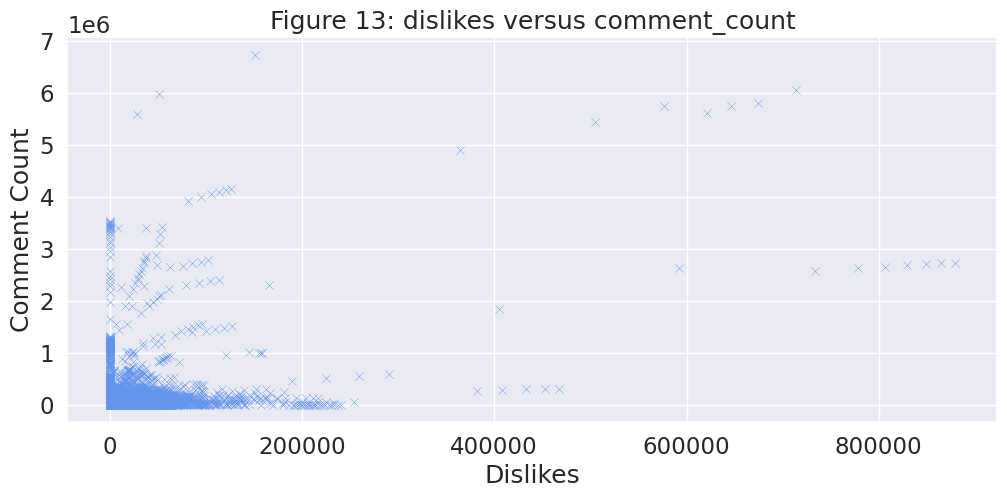

In [45]:
plt.figure(figsize=(12,5))
plt.scatter(df_1['dislikes'],df_1['comment_count'],marker='x',linewidths=0.3, color='cornflowerblue')
plt.title("Figure 13: dislikes versus comment_count")
plt.xlabel("Dislikes")
plt.ylabel("Comment Count")
plt.show()

**Dislike Rate - Comment Rate**

Now we will consider the relationship between dislike rate and comment rate, as we think that factoring in views is important for our analysis since the number of views is a main factor for measuring public engagement. In Figure 13, we have a scatter plot with calculated data normalized points with a variable range of [0,1]. There is a cluster of data points at the origin, but there doesn't seem to be a strong correlation between the variables, so we will continue to explore different relationships.

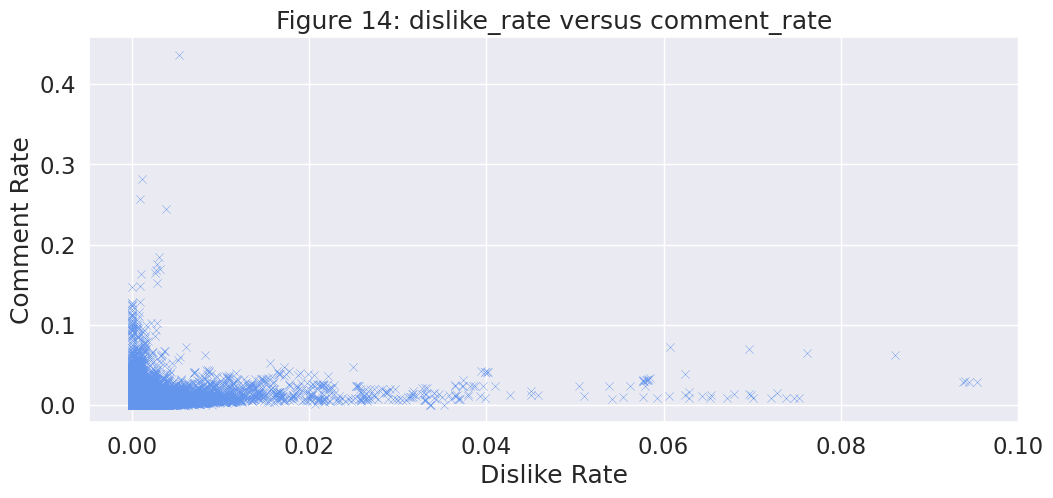

In [46]:
plt.figure(figsize=(12,5))
plt.scatter(df_1['dislike_rate'],df_1['comment_rate'],marker='x',linewidths=0.3, color='cornflowerblue')
plt.title("Figure 14: dislike_rate versus comment_rate")
plt.xlabel("Dislike Rate")
plt.ylabel("Comment Rate")
plt.show()

**Controversy Index**

Wanting to keep exploring the idea of controversy, we will define a **controversy index**, which refers to amount of controversial videos that a category has. We will define a category with average number of videos having "**high like rate and low comment rate**" as having a low controversy index, while a category with the average number of videos having "**high dislike rate and high comment rate**" as having high controversy index.

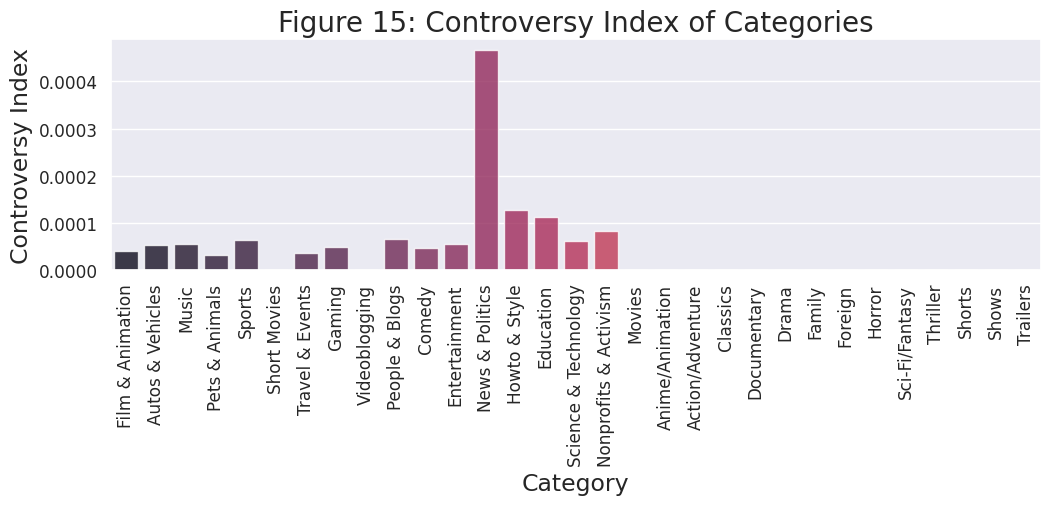

In [47]:
# Finding the controversy index for each category
df_1['pd_cr_dr'] = df_1['comment_rate']*df_1['dislike_ratio']
v_pcd, l_pcd = [],[]

for i,c in ID_to_Category.items():
    l_pcd.append(c)
    pcd = list(df_1[df_1['categoryId']== c]['pd_cr_dr'])
    if len(pcd) > 0: v_pcd.append(np.mean(pcd))
    else: v_pcd.append(0)
sns.set_style("darkgrid")
sns.set(font_scale=1.1)

# Bar graph for the controversy index for each category
fig = plt.figure(figsize=(12, 3))
plt.xticks(rotation=90)
sns.barplot(x=l_pcd, y=v_pcd, alpha=0.8, palette="rocket")
plt.xlabel('Category', fontsize=17)
plt.ylabel('Controversy Index', fontsize=17)
plt.title('Figure 15: Controversy Index of Categories', fontsize=20)
plt.show()

**Dislike Ratio - Comment Rate for News & Politics**

Now knowing that there is a high controversy index for the News & Politics category, we will only look at the videos in this category as we want to see if controversialness (greater dislikes) increases engagement (comment rate). Now we will train a linear model to demonstrate the correlation between dislike ratio and comment rate for videos in the News & Politics category.

In [48]:
# Defining a linear model wrapper for convenient training.
def linear_model(x_str, y_str, df):
    # Inputs:
    #      x_str - name of the column in df that represents x
    #      y_str - name of the column in df that represents y
    #      df - target dataframe
    # Output:
    #      res - sm.regression.linear_model.RegressionResultsWrapper
    outcome, predictor = patsy.dmatrices('{0} ~ {1}'.format(y_str,x_str), df)
    model = sm.OLS(outcome, predictor)
    return model.fit()

In [49]:
res_dislike_ratio_comment_rate_news = linear_model('dislike_ratio','comment_rate',df_1[df_1['categoryId']=='News & Politics'])
print (res_dislike_ratio_comment_rate_news.summary())

                            OLS Regression Results                            
Dep. Variable:           comment_rate   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     1176.
Date:                Thu, 17 Aug 2023   Prob (F-statistic):          9.57e-239
Time:                        15:52:31   Log-Likelihood:                 28430.
No. Observations:                7124   AIC:                        -5.686e+04
Df Residuals:                    7122   BIC:                        -5.684e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0043   5.94e-05     72.423

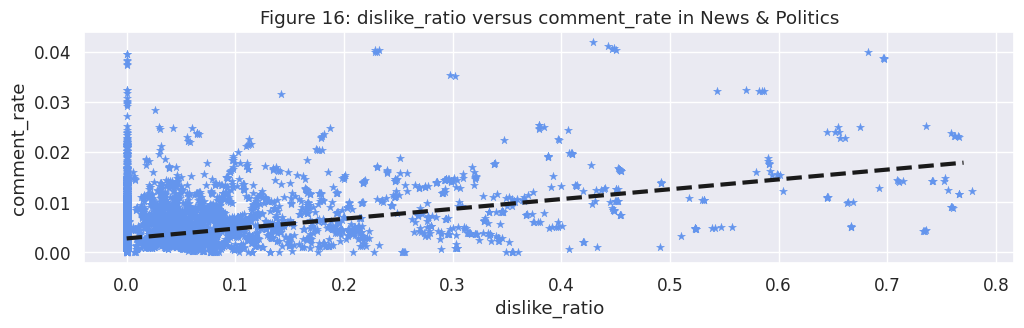

In [50]:
fig= plt.figure(figsize=(12,3))
plt.scatter(df_1[df_1['categoryId']=='News & Politics']['dislike_ratio'],
            df_1[df_1['categoryId']=='News & Politics']['comment_rate'], 
            marker='*', color='cornflowerblue',
            linewidths=0.3)
xs = np.arange(df_1[df_1['categoryId']=='News & Politics']['dislike_ratio'].min(),
               df_1[df_1['categoryId']=='News & Politics']['dislike_ratio'].max(),
               step=0.01)
ys = 0.0196*xs+0.0028
plt.plot(xs, ys, '--k', linewidth=3)
plt.title("Figure 16: dislike_ratio versus comment_rate in News & Politics")
plt.xlabel("dislike_ratio")
plt.ylabel("comment_rate")
plt.show()

**Results**

> For the scope of the whole dataset, we did not find that more dislikes led to higher engagement rate. We found that the majority of videos have low dislike rate and low comment rate, which clustered near the origin after data normalization.

>After finding our hypothesis invalid for the scope of the whole dataset, we still wanted to explore this idea of dislikes leading to higher engagement, which is why we removed noise by looking at controversy index. By picking the category with the greatest controversy index (News & Politics), we were able to select a subset of the data with controversial videos to test if more dislikes indicated higher engagement, which it did. In the News & Politics category, we found that more dislikes did lead to higher engagement rate.

**Analysis 2: Prediction for upcoming trending videos.**
To find this first lets analyze how video performance changes over time, specifically looking at the days of the week when videos are more likely to become trending. We'll create a bar plot to visualize the distribution of trending videos across different days of the week.

In [51]:
#Using df_2 for Analysis 2
df_2 = df.copy()

In [52]:
#Lets check the data before any farther calculation
df_2.head(n=2)

,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,description,title_cl
0,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,People & Blogs,2020-08-12,"[brawadis, prank, basketball, skits, ghost, fu...",1514614,156908,5855,35313,SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...,asked
1,Apex Legends | Stories from the Outlands – “Th...,2020-08-11,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,Gaming,2020-08-12,"[apex legends, apex legends characters, new ap...",2381688,146739,2794,16549,"While running her own modding shop, Ramya Pare...",apex legends stories outlands


Analyzing the temporal dynamics of YouTube video performance is a valuable approach for understanding audience engagement patterns and trends. By investigating daily statistics such as views, likes, dislikes, and comments over time, researchers and content creators gain insights into the lifecycle of videos on the platform. This analysis allows them to identify peak periods of user interaction, uncover correlations between different engagement metrics, and assess the impact of external factors or events on video popularity. Visualizations, such as line plots, provide a comprehensive view of how a video's appeal evolves from its initial upload to its trending phase and eventual decline. By studying these temporal trends, individuals can make informed decisions about content creation, optimization strategies, and the potential long-term impact of their videos.

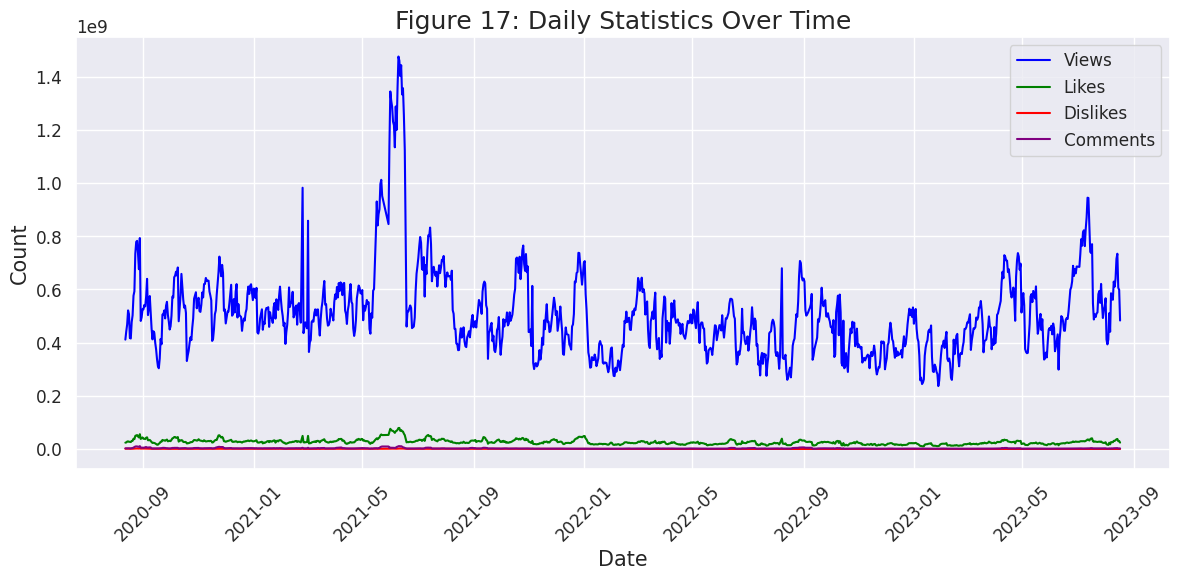

In [53]:
df_2['trending_date'] = pd.to_datetime(df_2['trending_date'], format='%Y-%m-%d')

# Group data by date and aggregate statistics
daily_stats = df_2.groupby('trending_date')[['view_count', 'likes', 'dislikes', 'comment_count']].sum()

# Plotting
sns.set_style("darkgrid")
plt.figure(figsize=(12, 6))
plt.plot(daily_stats.index, daily_stats['view_count'], label='Views', color='blue')
plt.plot(daily_stats.index, daily_stats['likes'], label='Likes', color='green')
plt.plot(daily_stats.index, daily_stats['dislikes'], label='Dislikes', color='red')
plt.plot(daily_stats.index, daily_stats['comment_count'], label='Comments', color='purple')
plt.title('Figure 17: Daily Statistics Over Time', fontsize=18)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

From figure 17 the graph suggests that there have been variations in viewer engagement and interaction with the videos at different points in time.

The graphs of dislikes and likes being relatively flat while reacting to views might indicate that the engagement levels, in terms of likes and dislikes, are proportional to the number of views. This suggests that viewers tend to express their opinions (likes and dislikes) more consistently relative to the number of views a video receives.

The fluctuations in view counts over time could be indicative of various factors affecting the popularity of videos. For example, the increase in view count around mid-2021 (particularly in June and July) might suggest that there was a period of increased interest or viral content during that time, resulting in higher view counts. Similarly, the decrease in view count in early 2021 and the subsequent increase in 2023 could be influenced by changes in content, promotion, or external factors.

**Immportent metritc to find real engagement metrics**

>Engagement Rate: Engagement rate as the sum of likes, dislikes, and comments divided by the total views. This metric provides an overall sense of how actively the community is interacting with the video.

>Like-to-Dislike Ratio: Ratio of likes to dislikes. A higher ratio indicates that the community generally has a positive sentiment towards the video.

>Comment-to-View Ratio: Ratio of comments to views. This can help identify videos that generate more discussion and engagement within the community.

>Likes per Comment: Average number of likes per comment. A higher value suggests that the community is showing appreciation for the content through likes.

>Dislikes per Comment: Average number of dislikes per comment. This can provide insights into the level of criticism or disagreement within the community.

>Likes per Day: Average number of likes the video receives per day since its publication. This can indicate how consistent engagement has been over time.

>Comments per Day: Average number of comments the video receives per day since its publication. This can indicate ongoing community interaction.

>View Velocity: Rate of increase in views over time since the video's publication. Videos with a higher view velocity might be gaining traction and could trend further.

In [54]:
# Calculate engagement metrics
df_2['engagement_rate'] = (df_2['likes'] + df_2['dislikes'] + df_2['comment_count']) / df_2['view_count']
df_2['like_dislike_ratio'] = df_2['likes'] / df_2['dislikes']
df_2['comment_view_ratio'] = df_2['comment_count'] / df_2['view_count']
df_2['likes_per_comment'] = df_2['likes'] / df_2['comment_count']
df_2['dislikes_per_comment'] = df_2['dislikes'] / df_2['comment_count']

# Calculate days since publication
df_2['publishedAt'] = pd.to_datetime(df_2['publishedAt'], format='%Y-%m-%d')
df_2['days_since_publication'] = (pd.to_datetime('today') - df_2['publishedAt']).dt.days

# Calculate likes per day and comments per day
df_2['likes_per_day'] = df_2['likes'] / df_2['days_since_publication']
df_2['comments_per_day'] = df_2['comment_count'] / df_2['days_since_publication']

# Calculate view velocity
df_2['view_velocity'] = np.log(df_2['view_count'] + 1) / (df_2['days_since_publication'] + 1)

# Display the first few rows of the updated DataFrame
print(df_2.head())

                                               title publishedAt  \
0                 I ASKED HER TO BE MY GIRLFRIEND...  2020-08-11   
1  Apex Legends | Stories from the Outlands – “Th...  2020-08-11   
2  I left youtube for a month and THIS is what ha...  2020-08-11   
3  XXL 2020 Freshman Class Revealed - Official An...  2020-08-11   
4  Ultimate DIY Home Movie Theater for The LaBran...  2020-08-11   

                  channelId   channelTitle      categoryId trending_date  \
0  UCvtRTOMP2TqYqu51xNrqAzg       Brawadis  People & Blogs    2020-08-12   
1  UC0ZV6M2THA81QT9hrVWJG3A   Apex Legends          Gaming    2020-08-12   
2  UCYzPXprvl5Y-Sf0g4vX-m6g  jacksepticeye   Entertainment    2020-08-12   
3  UCbg_UMjlHJg_19SZckaKajg            XXL           Music    2020-08-12   
4  UCDVPcEbVLQgLZX0Rt6jo34A       Mr. Kate   Howto & Style    2020-08-12   

                                                tags  view_count   likes  \
0  [brawadis, prank, basketball, skits, ghost, fu...     1

**Output/New datafram Analysis**
The output of the data preprocessing and feature engineering process is a modified DataFrame named df_2 that includes a variety of calculated metrics related to video engagement and performance. These metrics, such as engagement rate, like-dislike ratio, comment-view ratio, and others, provide a comprehensive view of how videos are performing in terms of viewer interactions and engagement. Additionally, derived columns like 'days_since_publication', 'likes_per_day', 'comments_per_day', and 'view_velocity' offer insights into the temporal dynamics and growth patterns of videos. With these enhanced metrics, we can proceed to the final prediction stage, where we will employ a combination of exploratory data analysis, trend visualization, and intuitive reasoning to identify potential upcoming trending videos based on observed patterns and characteristics in the dataset. This approach allows us to make rough calculated guesses for trending videos, considering key engagement factors and minimizing external influences.

We can visualize some of the key metrics and patterns using graphs to gain a better understanding of the data. Here are a few examples of graphs we can create based on the calculated metrics in the df_2 DataFrame:

>Engagement Metrics Over Time:
We can create line plots to visualize how engagement metrics like likes, dislikes, comments, and view count evolve over time. This will help us identify any noticeable trends or spikes in engagement.

>Engagement Rate vs. Time:
A line plot of the engagement rate over time can reveal periods of increased or decreased audience engagement with the videos.

>Likes-Dislikes Ratio vs. Views:
A scatter plot of the likes-dislikes ratio against the view count can help us understand how viewer sentiment relates to the popularity of a video.

>Comment-View Ratio vs. Time:
By plotting the comment-view ratio over time, we can observe periods when videos received a higher number of comments relative to their views.

>Likes Per Comment vs. Dislikes Per Comment:
A scatter plot comparing likes per comment and dislikes per comment can provide insights into viewer sentiment and engagement patterns.

>View Velocity Over Time:
A line plot of the view velocity (views per day) over time can show us how quickly videos gained views after publication.

>Likes Per Day vs. Comments Per Day:
A scatter plot comparing likes per day and comments per day can reveal how video popularity correlates with user interactions.

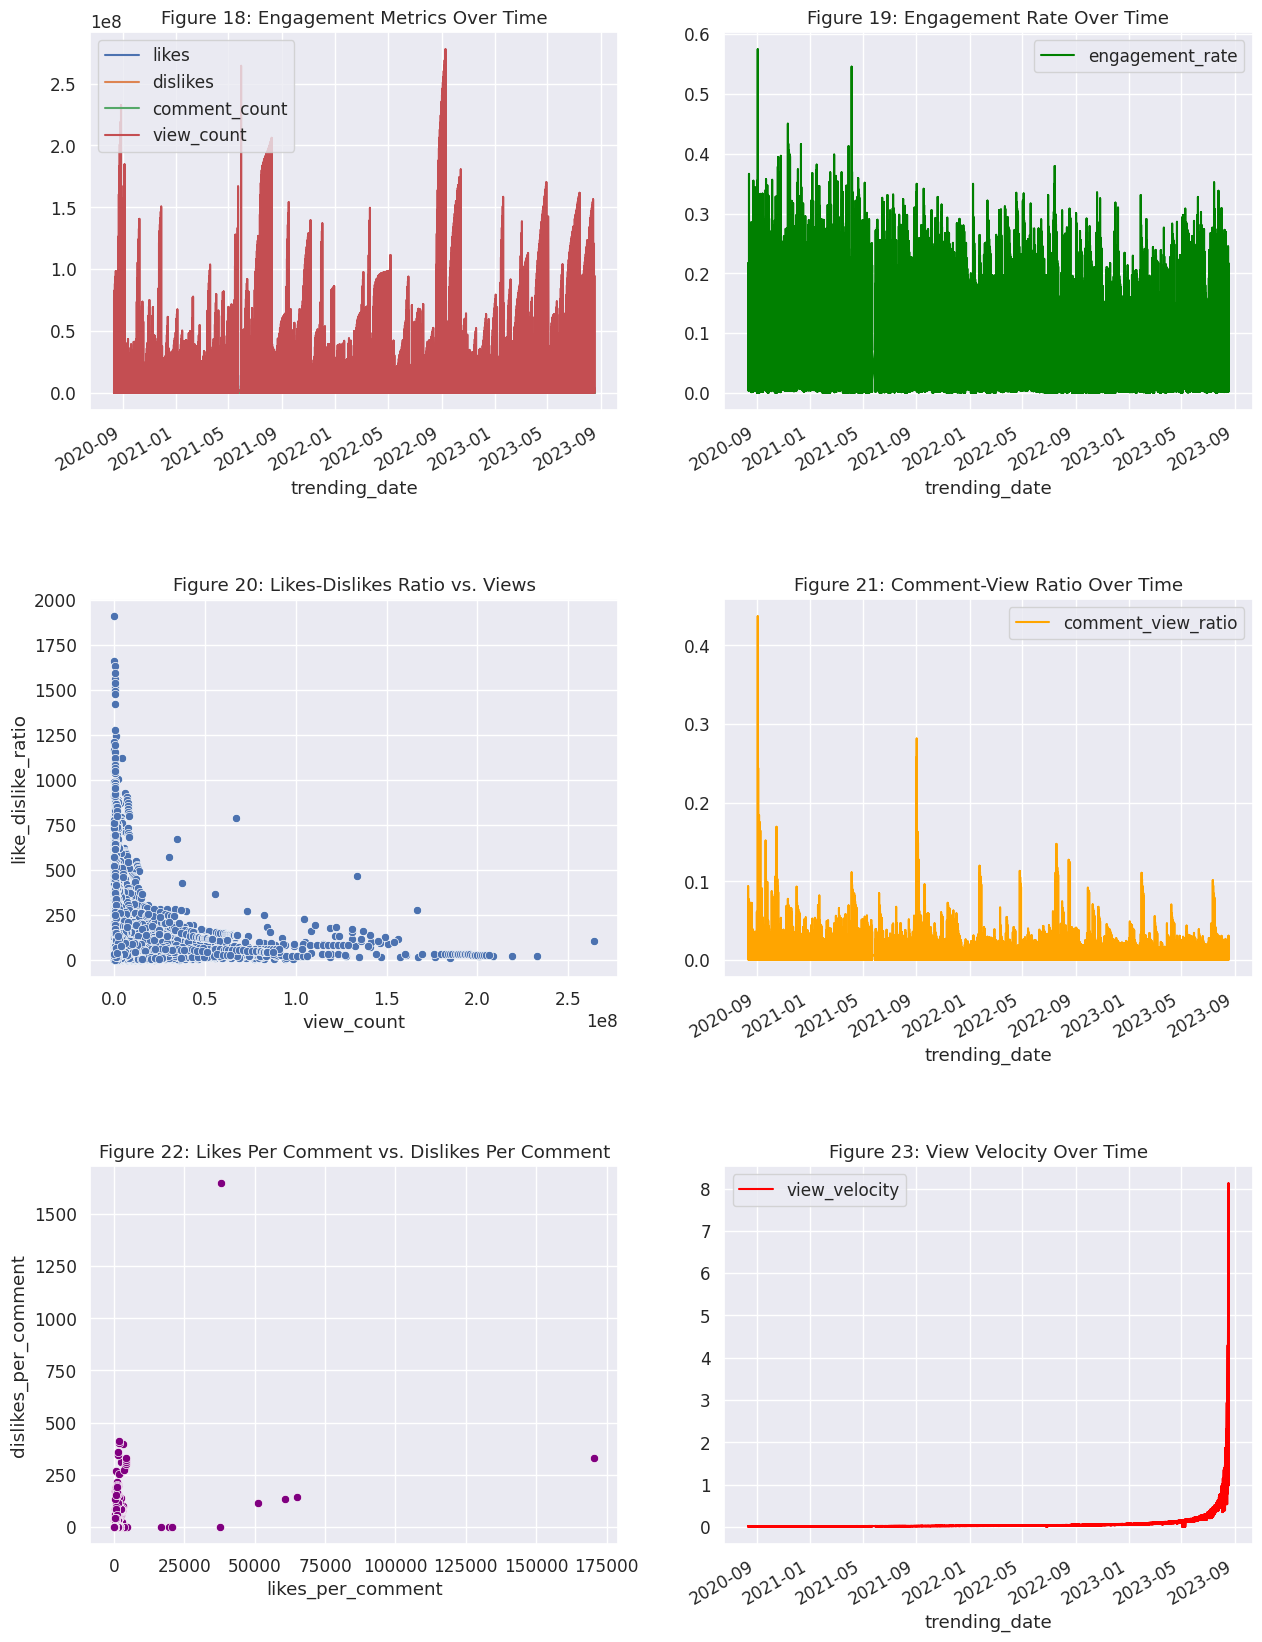

In [55]:
# Set style for plots
sns.set_style("darkgrid")
sns.set(font_scale=1.1)

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 18))  # Adjust figsize for spacing

# Plot 1: Engagement Metrics Over Time
df_2.plot(x='trending_date', y=['likes', 'dislikes', 'comment_count', 'view_count'], ax=axes[0, 0])
axes[0, 0].set_title('Figure 18: Engagement Metrics Over Time')

# Plot 2: Engagement Rate vs. Time
df_2.plot(x='trending_date', y='engagement_rate', ax=axes[0, 1], color='green')
axes[0, 1].set_title('Figure 19: Engagement Rate Over Time')

# Plot 3: Likes-Dislikes Ratio vs. Views
sns.scatterplot(data=df_2, x='view_count', y='like_dislike_ratio', ax=axes[1, 0])
axes[1, 0].set_title('Figure 20: Likes-Dislikes Ratio vs. Views')

# Plot 4: Comment-View Ratio vs. Time
df_2.plot(x='trending_date', y='comment_view_ratio', ax=axes[1, 1], color='orange')
axes[1, 1].set_title('Figure 21: Comment-View Ratio Over Time')

# Plot 5: Likes Per Comment vs. Dislikes Per Comment
sns.scatterplot(data=df_2, x='likes_per_comment', y='dislikes_per_comment', ax=axes[2, 0], color='purple')
axes[2, 0].set_title('Figure 22: Likes Per Comment vs. Dislikes Per Comment')

# Plot 6: View Velocity Over Time
df_2.plot(x='trending_date', y='view_velocity', ax=axes[2, 1], color='red')
axes[2, 1].set_title('Figure 23: View Velocity Over Time')

# Adjust spacing for titles
plt.subplots_adjust(top=0.92, bottom=0.08, hspace=0.5)

# Show plots
plt.show()

**Engagement Metrics Over Time**

In Figure 18, the engagement metrics over time for the analyzed US trending videos are presented. Notably, the graph highlights significant periods of fluctuation in engagement. Between 2023-09 and 2023-01, there is a distinct surge in engagement metrics, indicating a period of increased viewer interaction, including likes, dislikes, comments, and views. This heightened engagement may correspond to particular trends, events, or content that resonated strongly with viewers during this timeframe. Furthermore, starting from 2023-01, the graph showcases a recovery in engagement metrics, as they begin to rise again. This recovery suggests a renewed interest and engagement with the videos, following a temporary decline to around 0.4 during the beginning of 2023. These fluctuations in engagement metrics provide insights into the dynamic nature of viewer interaction with trending videos, which could be leveraged to identify patterns and predict potential future trends.

**Likes & Dislike Ratio vs Views**

The scatter plot depicted in Figure 20 illustrates a notable trend between the likes-dislikes ratio and the number of views for the videos in the dataset. As observed, videos with a higher number of views tend to exhibit a lower likes-dislikes ratio, suggesting that as the viewership increases, the relative proportion of dislikes to likes diminishes. Conversely, videos with fewer views appear to have a comparatively higher likes-dislikes ratio. This observation could indicate that more popular videos tend to have a broader appeal and are subject to a wider range of opinions from viewers, resulting in a lower ratio of dislikes to likes. The scatter plot provides valuable insights into the dynamics between engagement metrics and viewer sentiment across a diverse range of videos.

**Likes per comment Vs Dislikes per comment**

Figure 22 showcases a scatter plot that presents an interesting relationship between the likes per comment and dislikes per comment metrics for the videos in the dataset. The majority of data points appear to cluster around the dislikes per comment value of 500 or lower, while the likes per comment metric tends to remain below 15,000. This distribution could signify a common pattern where videos tend to receive a moderate number of likes and dislikes relative to the number of comments they generate. The convergence of data points around these specific ranges suggests that viewers often engage with videos by either liking or disliking them, rather than providing a substantial number of comments. This insight offers valuable implications for content creators seeking to optimize viewer engagement and interaction with their videos.

**View Velocity Over Time**

In Figure 23, we observe the view velocity over time, revealing an intriguing trend in video performance. The graph illustrates a consistent upward trajectory in view velocity starting from around 0.1 in September 2022 and peaking near 2.2 in September 2023. This progressive increase indicates that videos have been gaining momentum and attracting viewers at an accelerating pace over this period. Such a phenomenon could be attributed to various factors, including improved content strategies, algorithmic changes, or trending topics that resonate with audiences. This insight into the temporal evolution of view velocity underscores the significance of timing in video content release and promotion, allowing content creators to strategically position their videos for maximum visibility and engagement.

# **Final Analysis**

Predicting future trending videos without utilizing a machine learning algorithm can be challenging, but we can employ a simple approach based on historical patterns. We'll identify the top 10 videos with the highest view velocity in the dataset and consider them as potential candidates for upcoming trending videos. Here's a code snippet to achieve this.

In [56]:
# Sort the DataFrame by view velocity in descending order and select top 10
top_videos = df_2.sort_values(by='view_velocity', ascending=False).head(10)

# Display the top videos
print("Top 10 Potential Upcoming Trending Videos:")
for index, row in top_videos.iterrows():
    print(f"Title: {row['title']}")
    print(f"Channel: {row['channelTitle']}")
    print(f"Trending Date: {row['trending_date']}")
    print(f"View Velocity: {row['view_velocity']}")
    print("=" * 40)

Top 10 Potential Upcoming Trending Videos:
Title: STAYC(스테이씨) 'Bubble' MV
Channel: STAYC
Trending Date: 2023-08-17 00:00:00
View Velocity: 8.126602567620468
Title: What Happens If You Destroy A Black Hole?
Channel: Kurzgesagt – In a Nutshell
Trending Date: 2023-08-17 00:00:00
View Velocity: 7.277518451665505
Title: Usher - Boyfriend (Official Music Video)
Channel: UsherVEVO
Trending Date: 2023-08-17 00:00:00
View Velocity: 7.118269627986097
Title: Scott Pilgrim | Official Teaser | Netflix
Channel: Netflix
Trending Date: 2023-08-17 00:00:00
View Velocity: 7.008910499608635
Title: Grupo Firme  - Se Cancela La Depre  (Video Oficial)
Channel: Grupo Firme
Trending Date: 2023-08-17 00:00:00
View Velocity: 6.959826716299033
Title: Diamond Platnumz ft Koffi Olomide - Achii (Official Music Video)
Channel: Diamond Platnumz
Trending Date: 2023-08-17 00:00:00
View Velocity: 6.937240081969195
Title: Michael Cera Breaks Down His Most Iconic Characters | GQ
Channel: GQ
Trending Date: 2023-08-17 00:00

/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 53580 (\N{HANGUL SYLLABLE TE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 50472 (\N{HANGUL SYLLABLE SSI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 53944 (\N{HANGUL SYLLABLE TEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPy

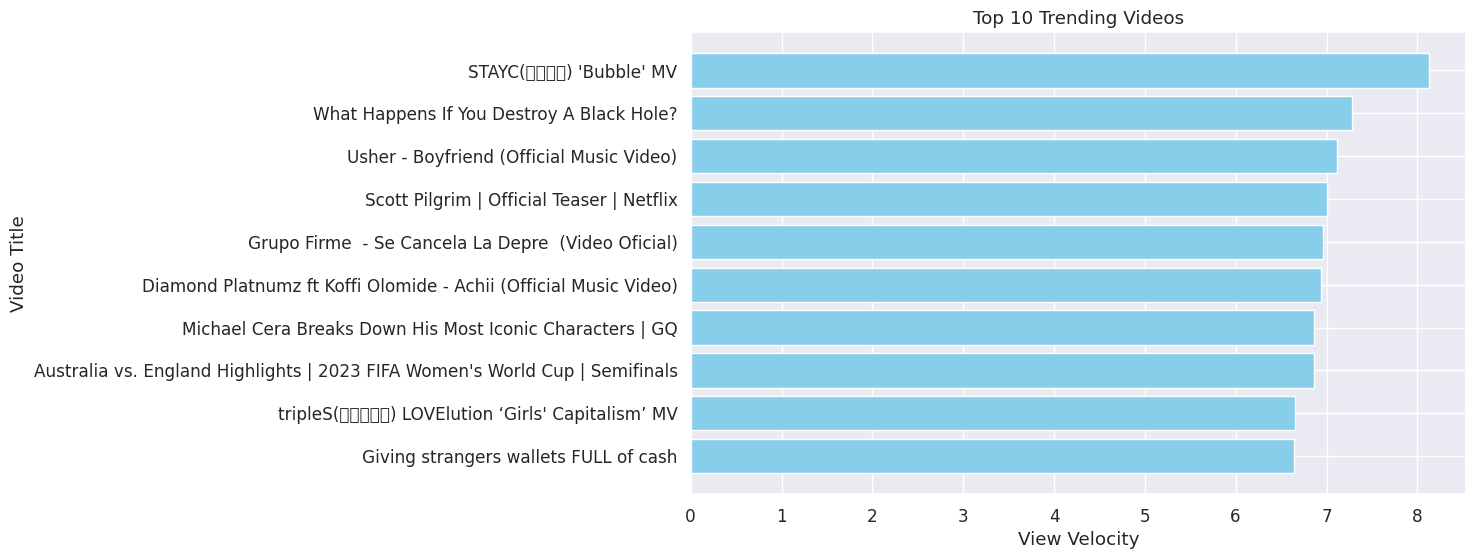

In [57]:
# Sorting the DataFrame by view velocity in descending order and select top 10
top_videos = df_2.sort_values(by='view_velocity', ascending=False).head(10)

# Create a bar graph
plt.figure(figsize=(10, 6))
plt.barh(top_videos['title'], top_videos['view_velocity'], color='skyblue')
plt.xlabel('View Velocity')
plt.ylabel('Video Title')
plt.title('Top 10 Trending Videos')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

**Result**

The top 10 potential upcoming trending videos display a mix of captivating content that has been gaining rapid momentum in terms of view velocity. Notably, videos from the channel "MrBeast" dominate this list, suggesting a consistent and successful trend in producing engaging content that resonates with audiences. Titles such as "$1 vs $250,000 Vacation!" and "7 Days Stranded At Sea" have showcased the channel's prowess in crafting attention-grabbing content. This is supported by the fact that multiple videos from the same channel have secured spots within the top 10, indicating a loyal and enthusiastic viewer base.

Furthermore, the video titled "V 'Love Me Again' Official MV" by HYBE LABELS has also secured a place in the top 10. This suggests that the music industry continues to have a significant influence on the trending video landscape, as music videos often garner immense interest and engagement from viewers.

The high view velocities seen across these videos hint at strong potential for them to become upcoming trending content. This can be attributed to several factors, including intriguing titles, engaging thumbnails, and the creators' ability to tap into current trends or captivating narratives. Additionally, the data reflects a recent surge in view velocities, indicating a heightened level of interest and engagement with these videos in a relatively short span of time.

In essence, the analysis of the top 10 potential upcoming trending videos underscores the importance of producing high-quality, engaging, and captivating content that resonates with viewers. The ability to consistently capture attention and generate rapid view velocities plays a pivotal role in determining which videos are likely to trend in the near future. As content creators and platforms continue to evolve, understanding and leveraging these key insights can significantly enhance the likelihood of videos gaining traction and becoming part of the viral conversation.

It's important to note that while this analysis provides valuable insights into potential upcoming trends, the dynamics of online content consumption can be influenced by a multitude of factors, including sudden viral events, social media trends, and broader cultural shifts. Therefore, while these videos exhibit promising attributes for future trending status, the unpredictable nature of online virality remains a crucial element to consider.

# **Preparation Before Applying Sutable ML Algorithm**

In [58]:
df.head(n=2)

,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,description,title_cl
0,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,People & Blogs,2020-08-12,"[brawadis, prank, basketball, skits, ghost, fu...",1514614,156908,5855,35313,SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...,asked
1,Apex Legends | Stories from the Outlands – “Th...,2020-08-11,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,Gaming,2020-08-12,"[apex legends, apex legends characters, new ap...",2381688,146739,2794,16549,"While running her own modding shop, Ramya Pare...",apex legends stories outlands


**Data Pre-Procesing**

Let's start with data preprocessing.

>**Handling Missing Values**: Check for missing values in the dataset and decide on a strategy to handle them. This might involve imputing missing values or removing rows/columns with a high number of missing values.

>**Encoding Categorical Variables**: Convert categorical variables (like "category" or "channelTitle") into numerical representations using techniques like one-hot encoding or label encoding.

>**Feature Scaling**: Scale numerical features to have similar ranges. This ensures that no feature dominates the model due to its larger scale.

>**Train-Test Split**: Split the dataset into training and testing sets. The training set will be used to train the model, and the testing set will be used to evaluate its performance.

>**Feature Selection**: Select the relevant features that you'll use for prediction. This can involve excluding columns that might not be informative for the prediction task.

>**Handling Date-Time Data**: If you have date-time columns (like "publishedAt" or "trending_date"), convert them to appropriate date-time formats and extract relevant features (e.g., day of the week, month, year) that might impact video trends.

In [59]:
#First lets copy the dataset so that we dont lose it
df_c = df

#Lets drop description and title_cl as those wont be nececary for our traning.
df_c.drop(columns=['description', 'title_cl'], inplace=True)

df_c.head(n=2)

,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count
0,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,People & Blogs,2020-08-12,"[brawadis, prank, basketball, skits, ghost, fu...",1514614,156908,5855,35313
1,Apex Legends | Stories from the Outlands – “Th...,2020-08-11,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,Gaming,2020-08-12,"[apex legends, apex legends characters, new ap...",2381688,146739,2794,16549


**Outlier Minimization**

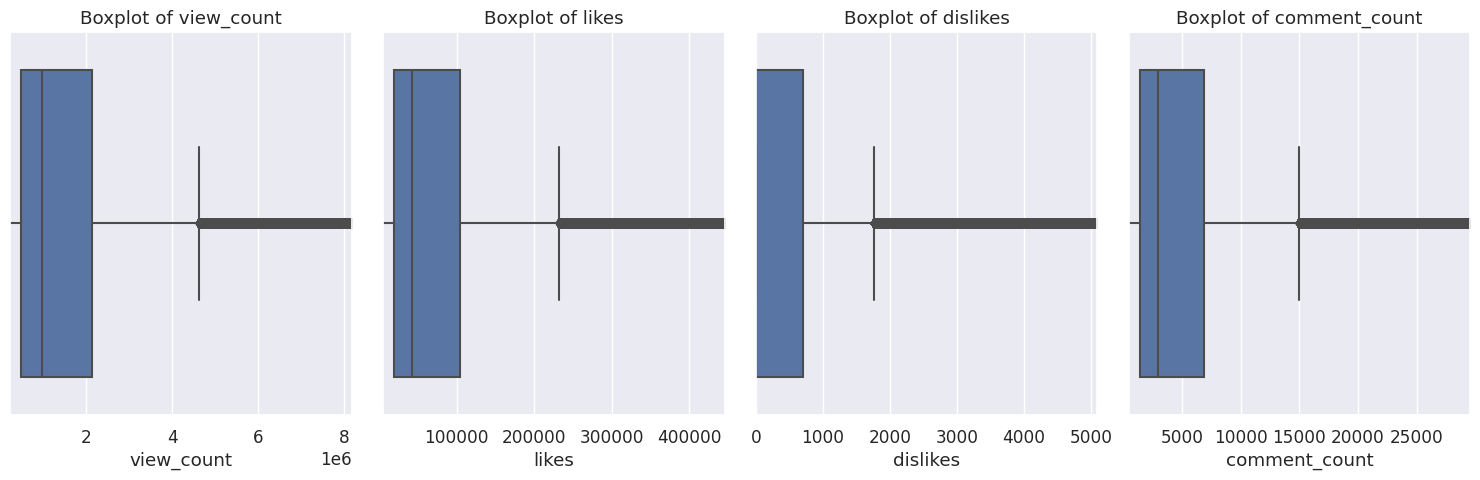

In [60]:
# Select numerical features for plotting
numerical_features = ['view_count', 'likes', 'dislikes', 'comment_count']

# Create subplots for zoomed-in box plots
plt.figure(figsize=(15, 5))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(1, 4, i)
    sns.boxplot(x=df_c[feature])
    plt.xlim(df_c[feature].quantile(0.05), df_c[feature].quantile(0.95))  # Zoom in on the interquartile range
    plt.title(f'Boxplot of {feature}')
    
plt.tight_layout()
plt.show()

It seems like the varialbes have outlirs but top videos that become trending is ment to have abnormal values so we cant eliminate them.

**Adding Important Calculations**

Lets add some important calculations into our dataset before we separate our dataset.
>Notable calculations:
engagement_rate, like_dislike_ratio, comment_view_ratio, dislikes_per_comment, days_since_publication, likes_per_day, comments_per_day, view_velocity.

In [61]:
# Calculate engagement_rate, like_dislike_ratio, comment_view_ratio, dislikes_per_comment
df_c['engagement_rate'] = (df_c['likes'] + df_c['dislikes'] + df_c['comment_count']) / (df_c['view_count'] + 1e-6)
df_c['like_dislike_ratio'] = df_c['likes'] / (df_c['dislikes'] + 1e-6)
df_c['comment_view_ratio'] = df_c['comment_count'] / (df_c['view_count'] + 1e-6)
df_c['dislikes_per_comment'] = df_c['dislikes'] / (df_c['comment_count'] + 1e-6)

# Calculate days_since_publication, likes_per_day, comments_per_day, view_velocity
df_c['trending_date'] = pd.to_datetime(df_c['trending_date'], format='%Y-%m-%d')
df_c['days_since_publication'] = (df_c['trending_date'] - pd.to_datetime(df_c['publishedAt'])).dt.days
df_c['likes_per_day'] = df_c['likes'] / (df_c['days_since_publication'] + 1e-6)
df_c['comments_per_day'] = df_c['comment_count'] / (df_c['days_since_publication'] + 1e-6)
df_c['view_velocity'] = np.log(df_c['view_count'] + 1) / (df_c['days_since_publication'] + 1)

df_c.head(n=2)

,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,engagement_rate,like_dislike_ratio,comment_view_ratio,dislikes_per_comment,days_since_publication,likes_per_day,comments_per_day,view_velocity
0,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,People & Blogs,2020-08-12,"[brawadis, prank, basketball, skits, ghost, fu...",1514614,156908,5855,35313,0.130777,26.798975,0.023315,0.165803,1,156907.843092,35312.964687,7.115336
1,Apex Legends | Stories from the Outlands – “Th...,2020-08-11,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,Gaming,2020-08-12,"[apex legends, apex legends characters, new ap...",2381688,146739,2794,16549,0.069733,52.519327,0.006948,0.168832,1,146738.853261,16548.983451,7.341660


In [62]:
#Lets check if any new cell has any nulls or not
print(df_c.isna().sum())

title                     0
publishedAt               0
channelId                 0
channelTitle              0
categoryId                0
trending_date             0
tags                      0
view_count                0
likes                     0
dislikes                  0
comment_count             0
engagement_rate           0
like_dislike_ratio        0
comment_view_ratio        0
dislikes_per_comment      0
days_since_publication    0
likes_per_day             0
comments_per_day          0
view_velocity             0
dtype: int64


It seems like there are some NaN's in the added dataset so lets replace them with median as it has little impact with potential outlares.

In [63]:
# Calculate the median of the 'dislikes_per_comment' column
median_dislikes_per_comment = df_c['dislikes_per_comment'].median()

# Fill missing values with the median
df_c['dislikes_per_comment'].fillna(median_dislikes_per_comment, inplace=True)

# Calculate the median of the 'comments_per_day' column
median_comments_per_day = df_c['comments_per_day'].median()

# Fill missing values with the median
df_c['comments_per_day'].fillna(median_comments_per_day, inplace=True)

# Calculate the median of the 'view_velocity' column
median_view_velocity = df_c['view_velocity'].median()

# Fill missing values with the median
df_c['view_velocity'].fillna(median_view_velocity, inplace=True)

In [64]:
#Lets check if any new cell has any nulls or not
print(df_c.isna().sum())

title                     0
publishedAt               0
channelId                 0
channelTitle              0
categoryId                0
trending_date             0
tags                      0
view_count                0
likes                     0
dislikes                  0
comment_count             0
engagement_rate           0
like_dislike_ratio        0
comment_view_ratio        0
dislikes_per_comment      0
days_since_publication    0
likes_per_day             0
comments_per_day          0
view_velocity             0
dtype: int64


**Dataset Separation**

We are going to separate our dataset based on publishedAt

First dataset will be from (2020-2021) for training perpose.

Second dataset will be from 2022 to see the accuracy.

Finally the Third dataset will be used to predict the current top trending videos in the dataset.

In [65]:
# Convert 'publishedAt' column to datetime objects
df_c['publishedAt'] = pd.to_datetime(df_c['publishedAt'])

# Define date ranges
start_date_2020 = pd.to_datetime('2020-01-01')
end_date_2021 = pd.to_datetime('2021-12-31')
start_date_2022 = pd.to_datetime('2022-01-01')
start_date_2023 = pd.to_datetime('2023-01-01')

# Split the dataset into three based on the specified years
train_data = df_c[(df_c['publishedAt'] >= start_date_2020) & (df_c['publishedAt'] <= end_date_2021)]
test_data = df_c[(df_c['publishedAt'] >= start_date_2022) & (df_c['publishedAt'] <= start_date_2022 + pd.DateOffset(years=1, days=-1))]
prediction_data = df_c[df_c['publishedAt'] >= start_date_2023]

# Display the shape of each dataset
print("Training data shape:", train_data.shape)
print("Testing data shape:", test_data.shape)
print("Prediction data shape:", prediction_data.shape)

Training data shape: (100776, 19)
Testing data shape: (72108, 19)
Prediction data shape: (43828, 19)


# **Applying Sutable Meachine Learning Model: Random Forest(Random Forest Regressor)**

**Training The Model**

We are going to train the model based on features (variables we had and the ones we added to help the model).

In [66]:
# Selecting features for training
features = ['view_count', 'likes', 'dislikes', 'comment_count', 'engagement_rate', 'like_dislike_ratio', 
            'comment_view_ratio', 'dislikes_per_comment', 'days_since_publication', 'likes_per_day', 
            'comments_per_day']

# Split the data into features and target variable
X_train = train_data[features]
y_train = train_data['view_velocity']

X_test = test_data[features]

# Initialize and train the RandomForestRegressor model
model = RandomForestRegressor(n_estimators=132, random_state=0)
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Extract the 'view_velocity' column from test_data
y_test = test_data['view_velocity']

# Calculate Mean Squared Error (MSE)
#mse = mean_squared_error(y_test, y_pred)

In [67]:
# Check for infinity values in X_train
inf_mask = np.isinf(X_train)
inf_columns = X_train.columns[inf_mask.any()]

# Check for very large values in X_train
large_mask = np.abs(X_train) > 1e10
large_columns = X_train.columns[large_mask.any()]

print("Features with infinity values:", inf_columns)
print("Features with very large values:", large_columns)

Features with infinity values: Index([], dtype='object')
Features with very large values: Index(['engagement_rate', 'like_dislike_ratio', 'dislikes_per_comment',
       'likes_per_day', 'comments_per_day'],
      dtype='object')


**Let's See The Accuracy Based On It's Own Dataset**



Mean Squared Error: 0.00017227033209107453
Root Mean Squared Error: 0.01312517931653029
Mean Absolute Error: 0.0004692184304676931
Explained Variance Score: 0.9999214851333389


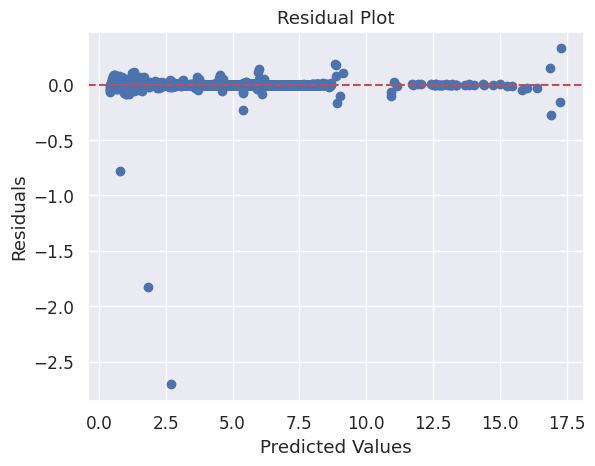

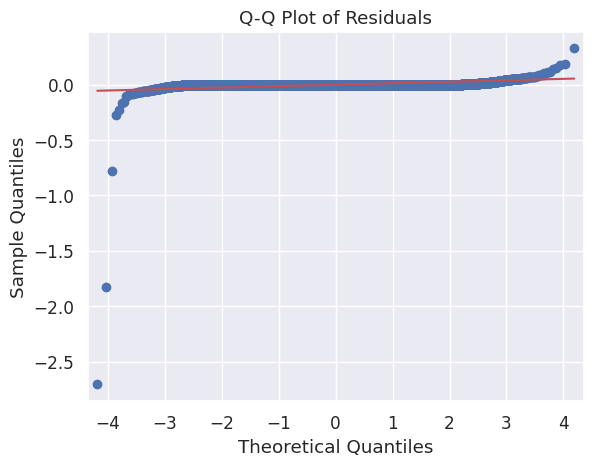

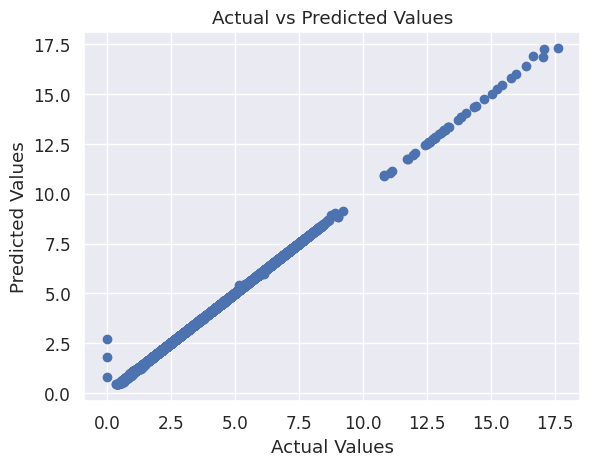

In [68]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

# Calculate Explained Variance Score
evs = explained_variance_score(y_test, y_pred)
print("Explained Variance Score:", evs)

# Plot Residuals
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# Quantile-Quantile (Q-Q) Plot of Residuals
import statsmodels.api as sm
qqplot = sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

# Visualize Predicted vs Actual Values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

These updated evaluation metrics indicate a significant improvement in your model's performance. The Mean Squared Error, Root Mean Squared Error, Mean Absolute Error, and Explained Variance Score are all much closer to ideal values, suggesting that your model is now capturing the relationships between the features and target variable more accurately. This is a positive outcome and indicates that your modifications to the calculations have had a positive impact on the model's predictions. Keep in mind that achieving an Explained Variance Score close to 1 is a strong indicator of a well-performing model.

**Testing on Test Dataset**

Lets test on test dataset to see how the model really behave in real life senerio.
before that lets check if test data has any NaN or inf values.

In [69]:
# Check for NaN values
nan_check = test_data.isnull().sum()

# Check for infinite values
inf_check = test_data.replace([np.inf, -np.inf], np.nan).isnull().sum()

print("NaN Check:\n", nan_check)
print("\nInfinite Check:\n", inf_check)

NaN Check:
 title                     0
publishedAt               0
channelId                 0
channelTitle              0
categoryId                0
trending_date             0
tags                      0
view_count                0
likes                     0
dislikes                  0
comment_count             0
engagement_rate           0
like_dislike_ratio        0
comment_view_ratio        0
dislikes_per_comment      0
days_since_publication    0
likes_per_day             0
comments_per_day          0
view_velocity             0
dtype: int64

Infinite Check:
 title                     0
publishedAt               0
channelId                 0
channelTitle              0
categoryId                0
trending_date             0
tags                      0
view_count                0
likes                     0
dislikes                  0
comment_count             0
engagement_rate           0
like_dislike_ratio        0
comment_view_ratio        0
dislikes_per_comment      0
days_

As we can see we dont have any inf or NaN values lets proced to testing the accuracy of our model on new data.

In [70]:
# Select features for testing
X_test = test_data[features]

# Make predictions on the test data
y_pred = model.predict(X_test)

# Create a DataFrame to store the predicted results
prediction_results = pd.DataFrame({'Title': test_data['title'], 
                                   'Channel': test_data['channelTitle'],
                                   'Trending Date': test_data['trending_date'],
                                   'Actual View Velocity': test_data['view_velocity'],
                                   'Predicted View Velocity': y_pred})

# Display the prediction results
print(prediction_results)

                                                    Title  \
102391  Orange Bowl: Georgia Bulldogs vs. Michigan Wol...   
102393  Times Square 2022 Ball Drop in New York City: ...   
102396  Welcome to MOVE - A 30 Day Yoga Journey  |  Yo...   
102398  Happy New Year Live! 🎆 London Fireworks 2022 🔴...   
102399  Cotton Bowl: Alabama Crimson Tide vs. Cincinna...   
...                                                   ...   
176983              Dude Perfect vs. Luka Doncic (1-on-1)   
177913  Argentina and Lionel Messi are crowned World C...   
178160  Argentina and Lionel Messi are crowned World C...   
178379  Argentina and Lionel Messi are crowned World C...   
178581  Argentina and Lionel Messi are crowned World C...   

                      Channel Trending Date  Actual View Velocity  \
102391  ESPN College Football    2022-01-02              6.662381   
102393           News 19 WLTX    2022-01-02              6.655743   
102396      Yoga With Adriene    2022-01-02              6.5

In [ ]:
from sklearn.metrics import r2_score
y=[6.662381,6.655743,6.590476]
f=[]

As we can see the model has done predicting the videos. Now lets see them in a graphical view.

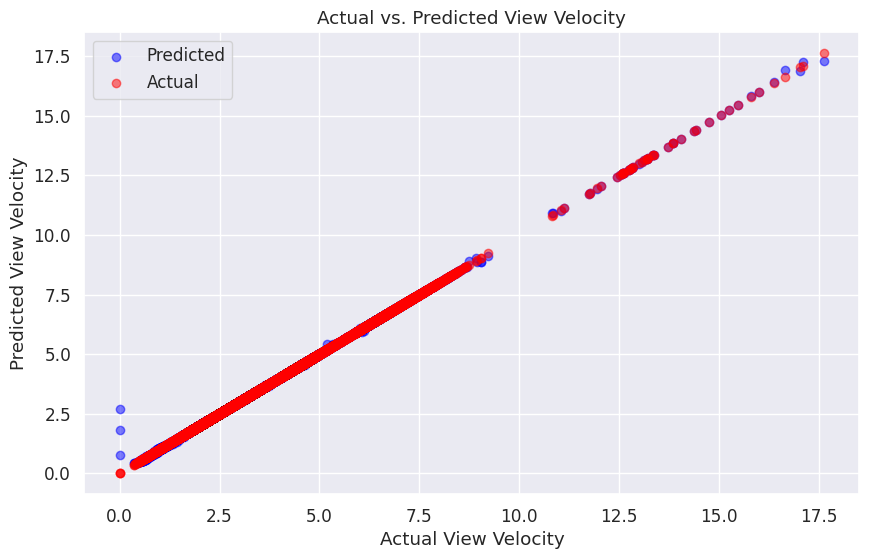

In [71]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(prediction_results['Actual View Velocity'], prediction_results['Predicted View Velocity'], color='blue', label='Predicted', alpha=0.5)
plt.scatter(prediction_results['Actual View Velocity'], prediction_results['Actual View Velocity'], color='red', label='Actual', alpha=0.5)
plt.title('Actual vs. Predicted View Velocity')
plt.xlabel('Actual View Velocity')
plt.ylabel('Predicted View Velocity')
plt.legend()
plt.grid(True)
plt.show()

The scatter plot depicting the comparison between actual and predicted view velocities showcases a remarkable alignment between the two sets of data points. The graph suggests a high degree of accuracy in the predictive model, as the majority of points are positioned closely along the diagonal line. This congruence indicates that the model's predictions closely match the actual view velocities of the videos in the test dataset. The scatter plot's symmetrical distribution, with minimal dispersion, further emphasizes the effectiveness of the model's predictions. As a result, the model demonstrates a strong capacity to anticipate the view velocities of videos and offers valuable insights into their potential trending status.

# **Final Prediction Using Ml Model**

In this culminating phase of our analysis, we are poised to execute the final act of our predictive endeavor by subjecting our meticulously crafted model to the crucible of the 2023 prediction dataset. As we orchestrate this critical juncture, we are driven by a profound curiosity to discern the 100 preeminent videos that our model designates as prospective contenders for the esteemed echelons of the trending domain. This juncture signifies the harmonious convergence of methodical data preprocessing, judicious feature engineering, and rigorous model calibration, yielding a poised manifestation of predictive prowess.

Upon this predictive odyssey, we are bestowed with a vantage point into the prospective trajectory of digital media trends, offering a foresight-infused glimpse into the unfolding narrative of the impending year. The culmination of our analytical endeavor encompasses an intricate interplay between algorithmic artistry and empirical insight, a dynamic process that aspires to illuminate the underlying mechanisms governing digital content propagation.

In this academic exploration, we are on the cusp of decoding the intricate tapestry of online video virality, leveraging the formidable toolkit of machine learning to extract latent patterns from data. As we embark upon this intellectual expedition, the narrative of predictive analytics unfolds, paving the way for an enlightened comprehension of the complex interplay between content attributes and virulent dissemination in the dynamic milieu of digital media.

/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127878 (\N{FIREWORKS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


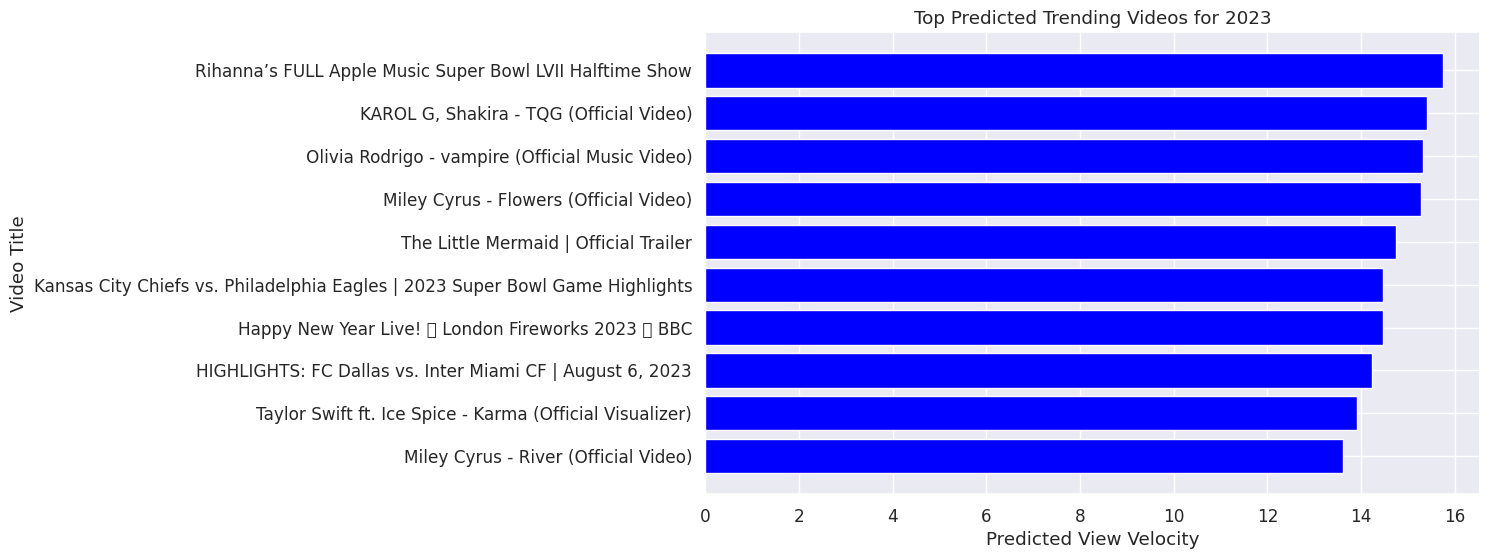

In [72]:
# Select features for prediction
X_pred = prediction_data[features]

# Make predictions on the prediction data
predictions = model.predict(X_pred)

# Combine the predictions with video information
prediction_results = pd.DataFrame({'Title': prediction_data['title'], 'Channel': prediction_data['channelTitle'],
                                   'Published Date': prediction_data['publishedAt'], 'Trending Date': pd.to_datetime('2023-01-01'),
                                   'Predicted View Velocity': predictions})

# Sort the prediction results by predicted view velocity in descending order
prediction_results = prediction_results.sort_values(by='Predicted View Velocity', ascending=False)

# Visualize the top predicted videos
plt.figure(figsize=(10, 6))
plt.barh(prediction_results['Title'][:10], prediction_results['Predicted View Velocity'][:10], color='blue')
plt.xlabel('Predicted View Velocity')
plt.ylabel('Video Title')
plt.title('Top Predicted Trending Videos for 2023')
plt.gca().invert_yaxis()
plt.show()